**Table of Contents**
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# RNAseq Alignment Exercise

The point of this notebook is to brush up on some basic Bioinformatics data-wrangling tasks.  I've sequenced a novel bacterial genome before, but a more common application relevant to future job searches is aligning RNAseq data, and thereby deriving tissue-specific gene expression patterns.

I got the initial data set from [here](https://usegalaxy.org/u/jeremy/p/galaxy-rna-seq-analysis-exercise).  I downloaded the data files to:

    C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq
    
on PC and:

    /Users/drew/Documents/Data/Python/Galaxy_rnaseq
    
on Mac.
    
I'll need fastqc, bowtie, cufflinks, tophat, and stuff.  The installation path for Ubuntu on Windows is:

    C:\Users\DMacKellar\AppData\Local\Lxss\rootfs
    
Just the dependencies for fastqc is >300MB, so I'll want to remember this location and possibly uninstall the tools when I'm done with them.

Docs for fastqc are [here](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/).

The raw reads for the Illumina BodyMap 2.0 project are [here](https://www.ncbi.nlm.nih.gov/sra?term=ERP000546&cmd=DetailsSearch).  There are 48 files, each with somewhere around 8E7 spots (potentially representing that many transcripts), for about 6-8E9 Bp per file.  A per-run listing is [here](https://www.ncbi.nlm.nih.gov/Traces/study/?WebEnv=NCID_1_3553855_165.112.9.35_5555_1504758348_3507660845_0MetA0_S_HStore&query_key=2).

# General Points

RNA-seq alignment and quantification involves specific assumptions about methodology that are distinct from those of processing DNA reads for genome sequencing.

General info about the Illumina Body Map 2 is available from several sources.  One note on methodology from [this talk](https://personal.broadinstitute.org/mgarber/bodymap_schroth.pdf):

    The samples used for the 2X50 and 1X75 bp runs are prepared
    using the Illumina mRNA-Seq kit. 
        – These libraries are made from poly-A selected mRNA 
        – They are made with a random priming process and are not stranded. 
        – The insert size for the PE libraries is about ~210 bps
        
16 Human tissues are represented in the project, and for each tissue they ran one whole lane of a HiSeq2000 sequencer, mixing the paired-end and 1x75 sequences.

As a side project, they pooled total RNA from each of the 16 tissues, then subjected the pooled RNAs to each of three different treatments:

– Total Poly-A selected mRNA<br />
– Total Poly-A selected mRNA with Normalization<br />
– Total RNA – no Poly-A Selection – to enrich for non-coding RNA
 - Complete Transcriptome Library Prep Method to capture all RNA species
 - Uses New Illumina protocol for reducing rRNA in whole transcriptome analysis

Apparently, the point of this latter approach was to validate a new protocol they had developed that was meant to enrich non-rRNA in a sample.  From each of these pooled runs they collected 1x100bp reads per sequence.

---

### Quality Control

Assessing sequence and base quality and trimming accordingly can be done with a combination of [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) and Trimmomatic, or via [BioPython](http://biopython.org/DIST/docs/api/Bio.SeqIO.QualityIO-module.html).

We can get a preliminary look at the fastq format by simply opening the Bash shell and typing

    less [filename.fastq]
    
In the case of the example files downloaded from the site listed above, the first three reads in '`Galaxy2-[adrenal_1.fastq\].fastqsanger`' are:

    @ERR030881.107 HWI-BRUNOP16X_0001:2:1:13663:1096#0/1
    ATCTTTTGTGGCTACAGTAAGTTCAATCTGAAGTCAAAACCAACCAATTT
    +
    5.544,444344555CC?CAEF@EEFFFFFFFFFFFFFFFFFEFFFEFFF
    @ERR030881.311 HWI-BRUNOP16X_0001:2:1:18330:1130#0/1
    TCCATACATAGGCCTCGGGGTGGGGGAGTCAGAAGCCCCCAGACCCTGTG
    +
    GFFFGFFBFCHHHHHHHHHHIHEEE@@@=GHGHHHHHHHHHHHHHHHHHH
    @ERR030881.1487 HWI-BRUNOP16X_0001:2:1:4144:1420#0/1
    GTATAACGCTAGACACAGCGGAGCTCGGGATTGGCTAAACTCCCATAGTA
    +
    55*'+&&5'55('''888:8FFFFFFFFFF4/1;/4./++FFFFF=5:E#

As can be seen, the reads are all cheek-to-jowl, with no lines separating them.  The eye is drawn to the whitespace of the lines that contain only '`+`', but that line doesn't come between different reads, but rather separates the lines containing base pair calls and their respective quality scores.  In fact, the line order goes:

* Unique Read Identifier; details on interpretation [available from Wikipedia](https://en.wikipedia.org/wiki/FASTQ_format#Illumina_sequence_identifiers).  The first few characters that are in common among all reads in the file are usually either designate the specific machine on which they were sequenced or, as here, are the string under which the data were registered on the [NCBI Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra).  Specifically, in this case, the page is [here](https://www.ncbi.nlm.nih.gov/sra/?term=ERR030881).

* Base Calls; I believe the only valid values are ['A', 'C', 'G', 'T', and 'N'].

* A spacer line containing '+'.  Despite appearance, it doesn't necessarily denote any kind of assumption about which strand of DNA in the chromosome from which the read originates; they're all supposed to be '+'.

* Quality scores; base quality scores can be interpreted with the info [here](http://www.drive5.com/usearch/manual/quality_score.html).  The encoding apparently differs between platform, however, so attention must be paid to what machine/technology generated the reads.

After those four lines, the next read comes immediately, with no separating line.

---

#### FastQC

I intend to try BioPython's SeqIO module later, but I am more familiar with FastQC, and will use it first to analyze these example data.  FastQC can be run in a GUI mode, in an independent window.  Opening a '`.fastq`' file within that automatically reads all sequences within and offers several tabs of summary data, and prints an icon beside the title of each tab that summarizes whether or not FastQC considers the output problematic for future integration into a mapping/assembly pipeline.

In [2]:
import pandas as pd

# Get table of library data from:
# https://www.ncbi.nlm.nih.gov/Traces/study/?WebEnv=NCID_1_3553855_165.112.9.35_5555_1504758348_3507660845_0MetA0_S_HStore&query_key=2
# https://www.ncbi.nlm.nih.gov/Traces/study/?acc=ERP000546

mac_table_path = '/Users/drew/Documents/Data/Python/Galaxy_rnaseq/SraRunTable.txt'
pc_table_path = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\SraRunTable.txt'

# On PC:
table_path = pc_table_path
# On Mac:
# table_path = mac_table_path

sra_table = pd.DataFrame.from_csv(table_path, sep='\t')

print('Table shape: ', sra_table.shape)
print('Unique Biosamples: ', sra_table['BioSample_s'].unique().shape)
print('Unique Experiments: ', sra_table['Experiment_s'].unique().shape, '\n')
print('Library types:\n{0}'.format(
      sra_table['LibraryLayout_s'].value_counts()), '\n')
print('Experiments per tissue type:\n{0}'.format( 
      sra_table['OrganismPart_s'].value_counts()))
# sra_table[sra_table['OrganismPart_s'] == 'brain']
sra_table.head()

Table shape:  (48, 27)
Unique Biosamples:  (19,)
Unique Experiments:  (48,) 

Library types:
SINGLE    32
PAIRED    16
Name: LibraryLayout_s, dtype: int64 

Experiments per tissue type:
16 Tissues mixture    16
brain                  2
ovary                  2
prostate               2
adrenal                2
lung                   2
heart                  2
kidney                 2
thyroid                2
testes                 2
colon                  2
white blood cells      2
skeletal muscle        2
liver                  2
breast                 2
adipose                2
lymph node             2
Name: OrganismPart_s, dtype: int64


C:\Python\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  from ipykernel import kernelapp as app


,AvgSpotLen_l,BioSample_s,BioSourceProvider_s,Experiment_s,InsertSize_l,LibraryLayout_s,Library_Name_s,MBases_l,MBytes_l,OrganismPart_s,...,Center_Name_s,Consent_s,Instrument_s,LibrarySelection_s,LibrarySource_s,LoadDate_s,Organism_s,Platform_s,ReleaseDate_s,SRA_Study_s
Age_s,,,,,,,,,,,,,,,,,,,,,
NaN,100,SAMEA962337,NaN,ERX011226,0,SINGLE,HCT20170,7290,4098,16 Tissues mixture,...,"Illumina, Inc. 25861 Industrial Blvd Hayward, ...",public,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
NaN,100,SAMEA962337,NaN,ERX011216,0,SINGLE,HCT20170,7461,4190,16 Tissues mixture,...,"Illumina, Inc. 25861 Industrial Blvd Hayward, ...",public,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
NaN,100,SAMEA962337,NaN,ERX011224,0,SINGLE,HCT20170,7365,4151,16 Tissues mixture,...,"Illumina, Inc. 25861 Industrial Blvd Hayward, ...",public,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
NaN,100,SAMEA962346,NaN,ERX011189,0,SINGLE,HCT20172,7274,4097,16 Tissues mixture,...,"Illumina, Inc. 25861 Industrial Blvd Hayward, ...",public,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
NaN,100,SAMEA962346,NaN,ERX011223,0,SINGLE,HCT20172,7241,4062,16 Tissues mixture,...,"Illumina, Inc. 25861 Industrial Blvd Hayward, ...",public,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546


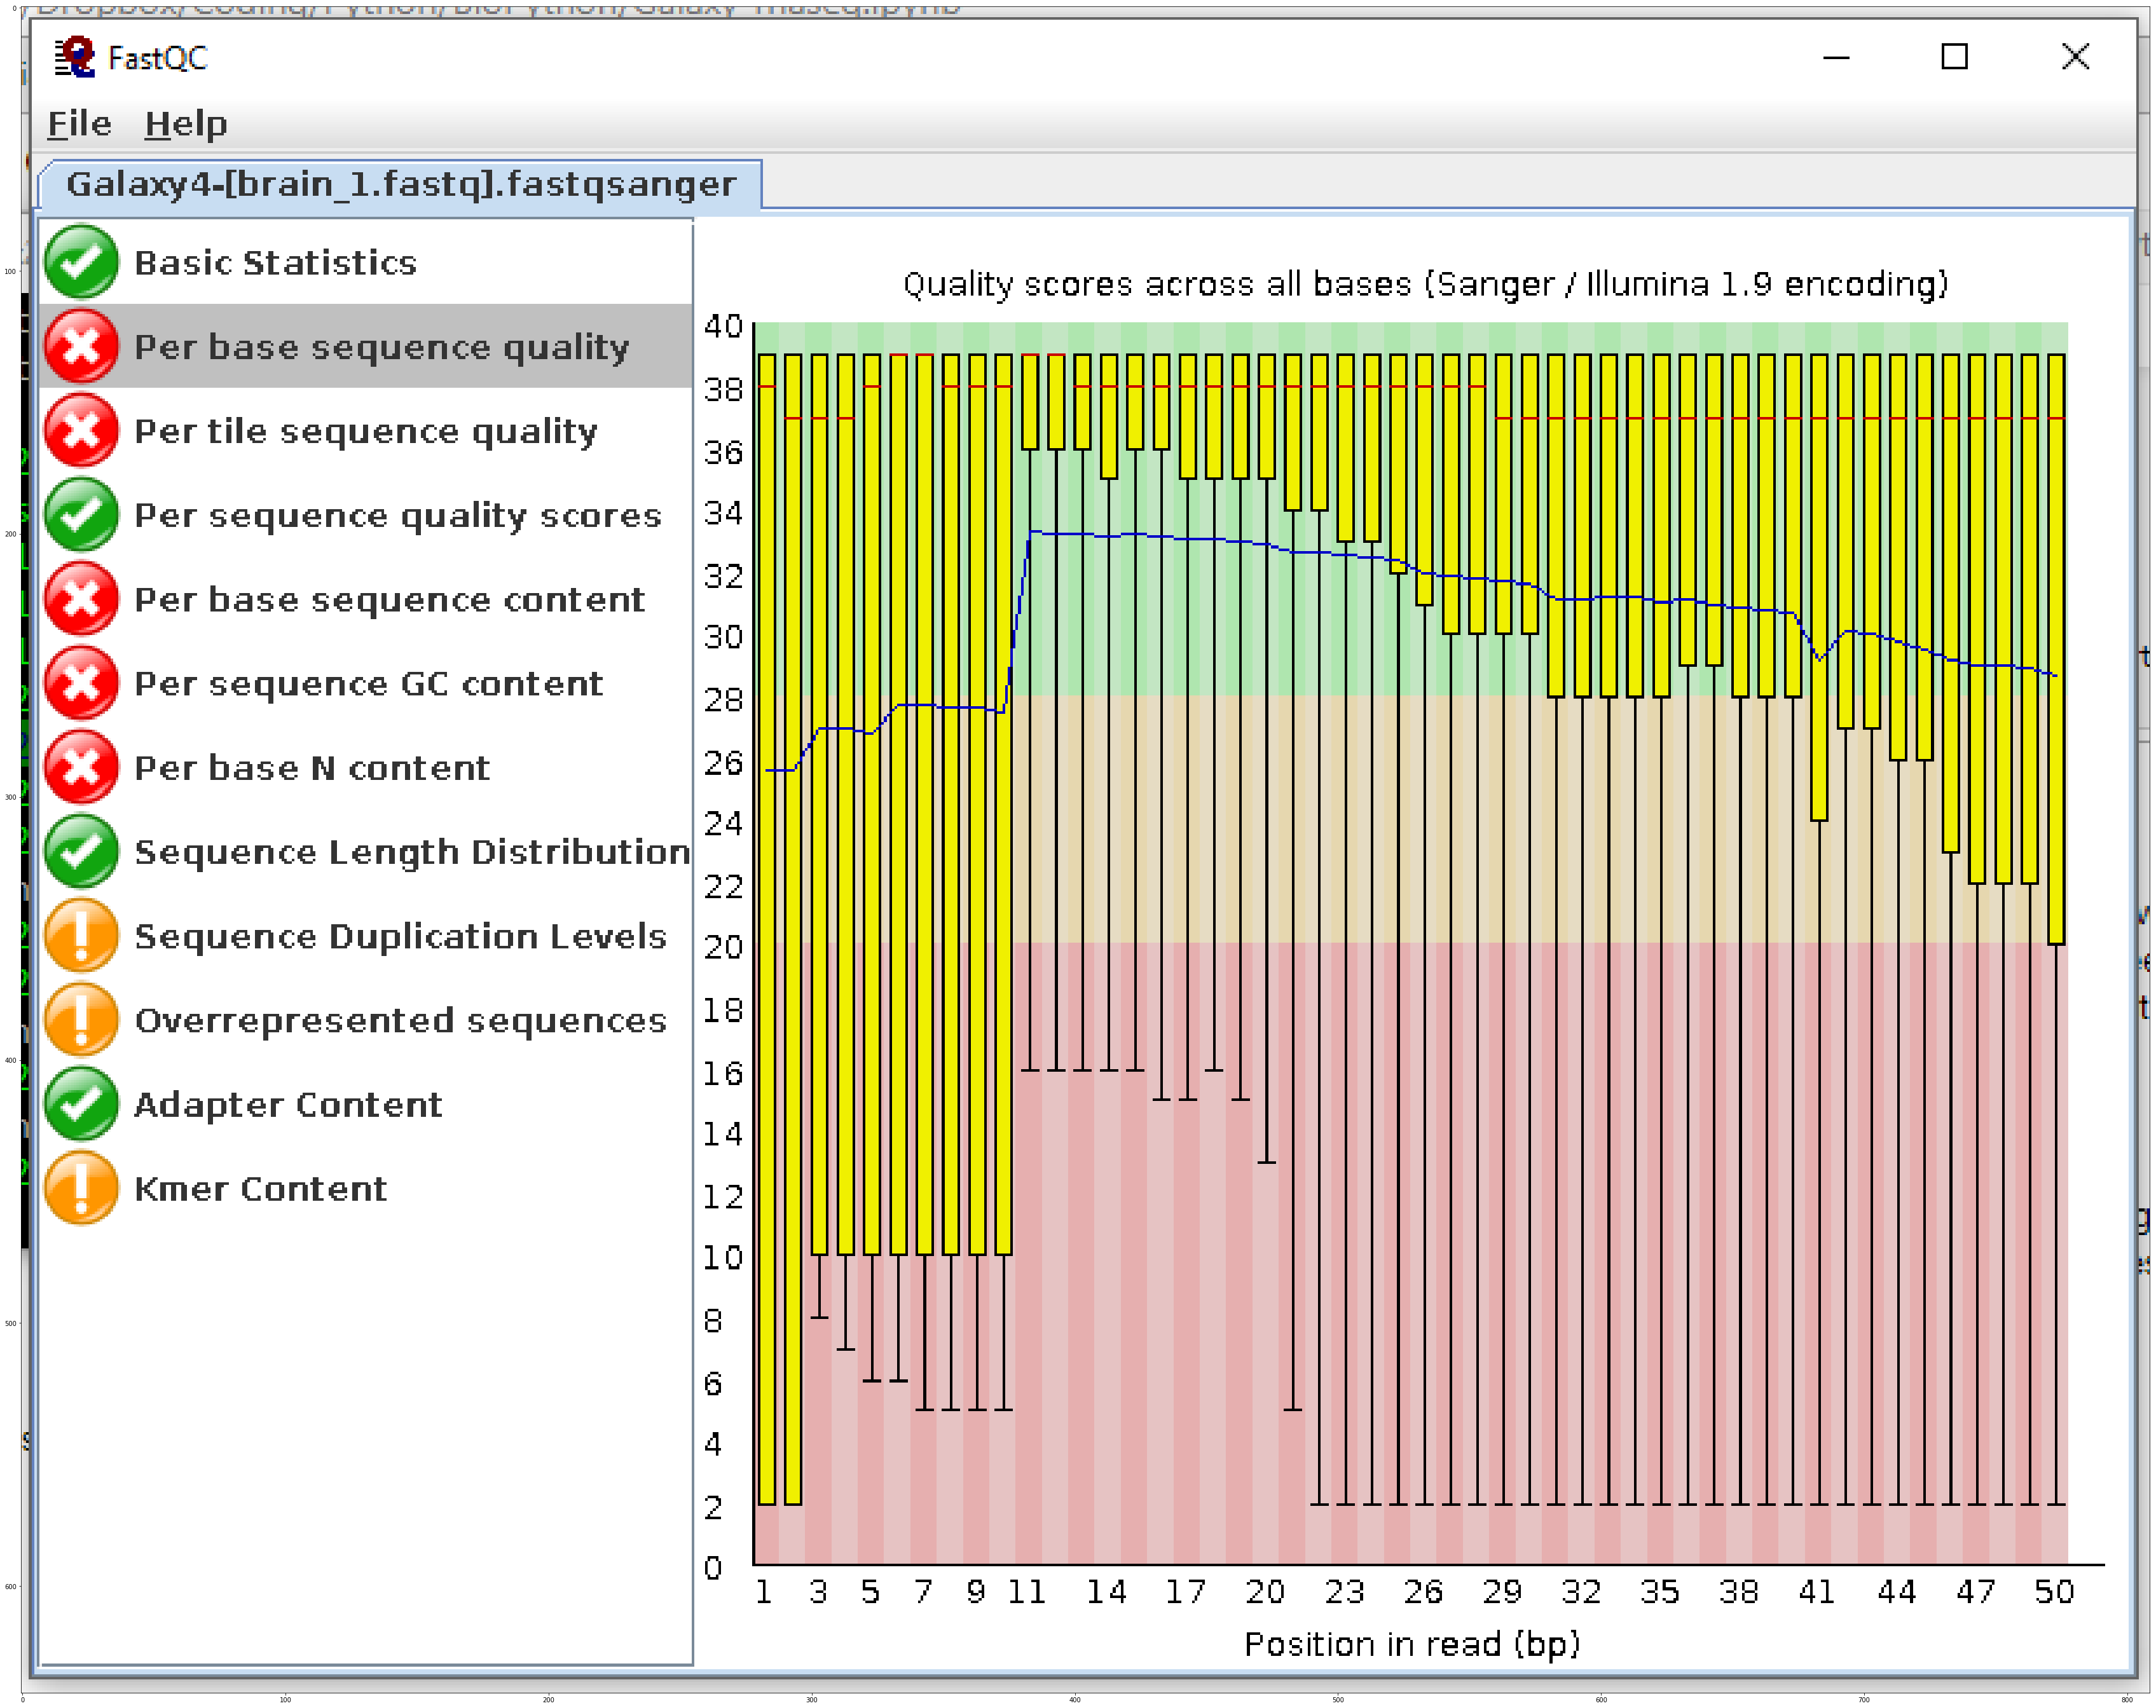

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(60, 80))
# Screen Capture on PC:
plt.imshow(plt.imread(r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\fastqc_screen_capture.png'))
plt.show()

As the website listed above for this exercise notes, FastQC was mostly built around genome assembly applications, and so the quality scores and assumptions about suitability for each sequence or base may not always be appropriate for other purposes, such as RNA-seq.  So the icons summarizing each tab aren't to be considered definitive.

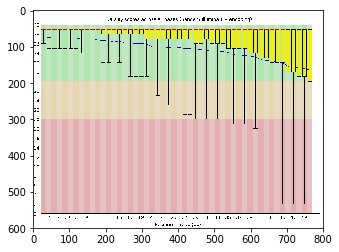

In [4]:
from matplotlib import pyplot as plt
from matplotlib import image
import os

fastq3_dir = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\Galaxy3-[adrenal_2.fastq].fastqsanger_fastqc\Galaxy3-[adrenal_2.fastq].fastqsanger_fastqc\Images'

base_qual = image.imread(os.path.join(fastq3_dir, 'per_base_quality.png'))
plt.imshow(base_qual)
plt.show()
# type(base_qual)
# base_qual.shape

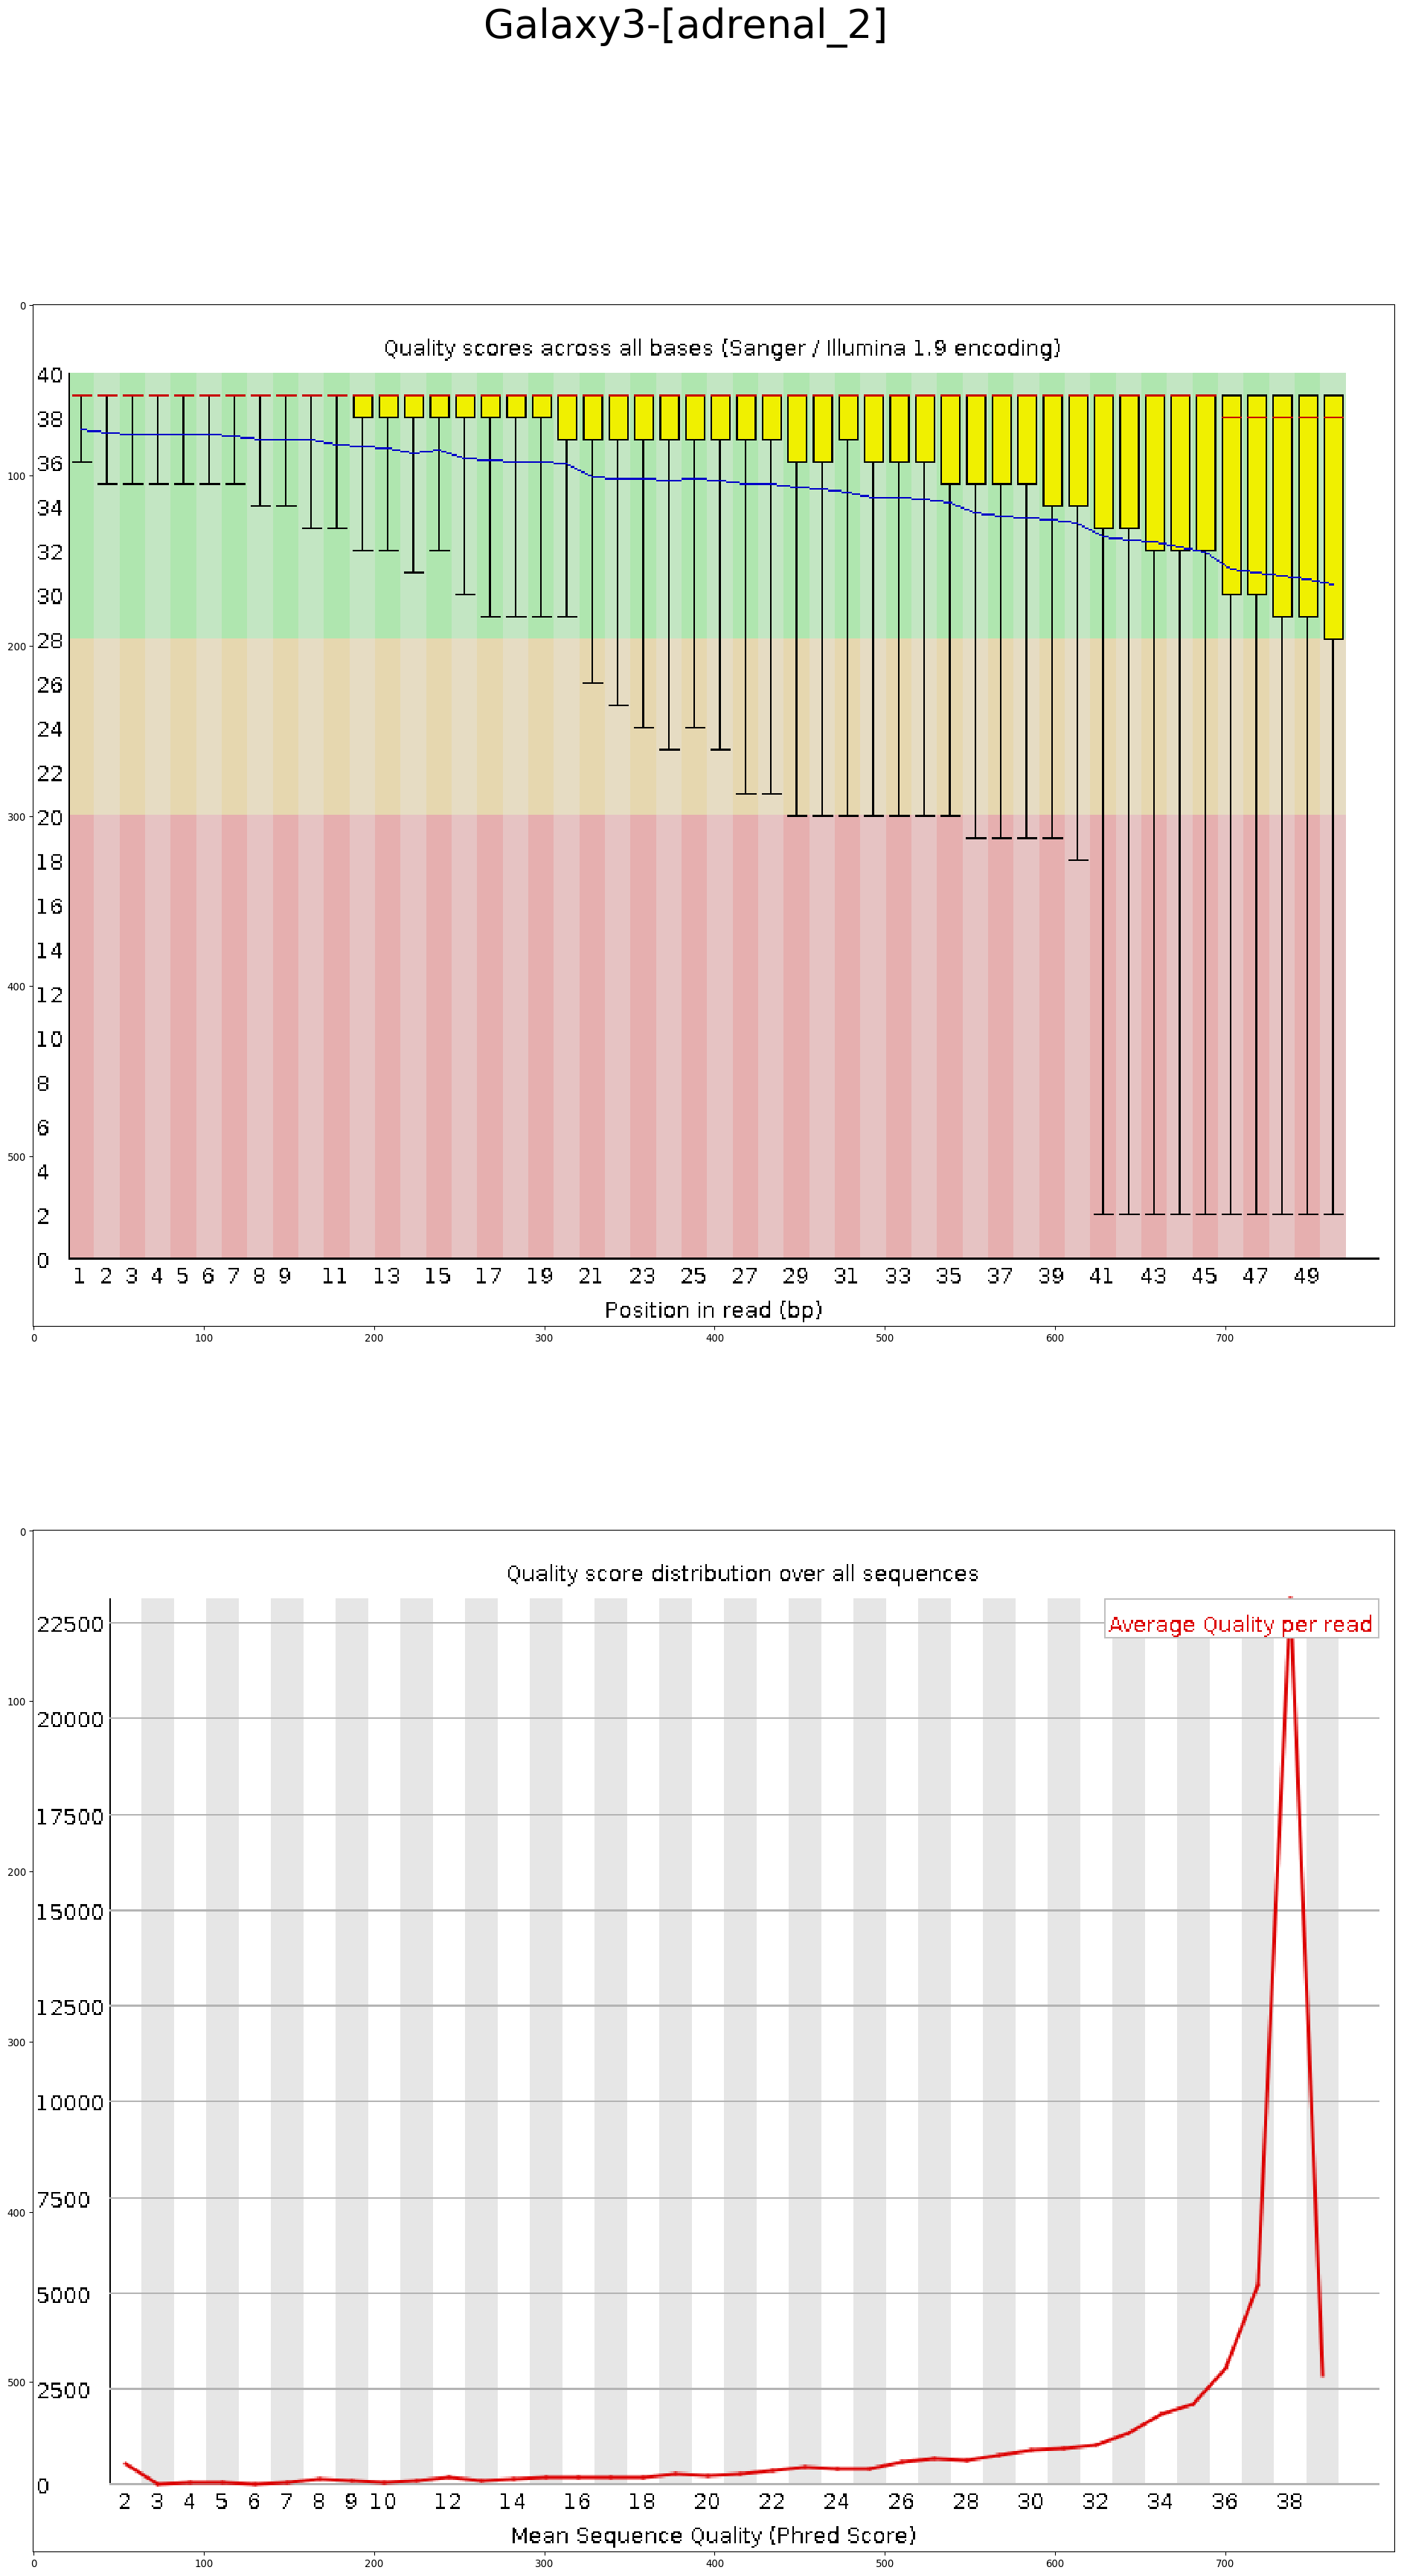

In [5]:
from matplotlib import pyplot as plt
from matplotlib import image
import os

plt.close('all')

fastq3_dir = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\\
Galaxy3-[adrenal_2.fastq].fastqsanger_fastqc\Galaxy3-[adrenal_2.fastq].fastqsanger_fastqc\Images'

# fig = plt.figure(figsize=(20, 40))
my_dpi = 96
# plt.figure(figsize=(60, 80))#600/my_dpi, 800/my_dpi), dpi=my_dpi)
fig_scale = 500
fig, axs = plt.subplots(2, 1, figsize=(6*fig_scale/my_dpi, 8*fig_scale/my_dpi), dpi=my_dpi)
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)

axs[0].imshow(image.imread(os.path.join(fastq3_dir, 'per_base_quality.png')))
axs[1].imshow(image.imread(os.path.join(fastq3_dir, 'per_sequence_quality.png')))

fig.suptitle('Galaxy3-[adrenal_2]', fontsize=0.08 * fig_scale)
# plt.tight_layout()
# axs[0].set_title('Galaxy3-[adrenal_2]')
plt.show()

I would like a general-purpose function to print specific graphs from each FastQC output.  Once FastQC has run, it outputs a zip file.  When extracted, this has the general structure 

    [dir the fastq file was in] / [dir with same name as the fastq file]\_fastqc / 'Images' / 'per_base_quality.png'
    
or 

    [dir the fastq file was in] / [dir with same name as the fastq file]\_fastqc / 'Images' / 'per_sequence_quality.png'

In [6]:
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_fastqc(outer_dir):
    fastqc_plots = defaultdict()
    pattern1 = re.compile(r'(.*)\.fastq.*')
    
    # get all files and subdirectories in the dir containing the fastq files
    for root, dirs, files in os.walk(outer_dir):
        for file in files:
            # look for the 'per_base_quality' files
            if file == 'per_base_quality.png':
                # split the path to that file into drives/dirs
                subdirs = root.split(os.sep)
                # get just the part of the penultimate dir that's unique
                # put it in the dict, make a subdict called per_base and set the
                # image as its item
                fastq_name = re.search(pattern1, subdirs[-2]).group(1)
                fastqc_plots[fastq_name] = {}
                fastqc_plots[fastq_name].update({'per_base' : os.path.join(root, file)})
            elif file == 'per_sequence_quality.png':
                subdirs = root.split(os.sep)
                fastq_name = re.search(pattern1, subdirs[-2]).group(1)
                fastqc_plots[fastq_name].update({'per_sequence' : os.path.join(root, file)})
            elif file == 'per_base_sequence_content.png':
                subdirs = root.split(os.sep)
                fastq_name = re.search(pattern1, subdirs[-2]).group(1)
                fastqc_plots[fastq_name].update({'per_base_sequence_content' : os.path.join(root, file)})
#             elif file == 'kmer_profiles.png':
#                 subdirs = root.split(os.sep)
#                 fastq_name = re.search(pattern1, subdirs[-2]).group(1)
#                 blah = fastqc_plots.get(fastq_name, None)
#                 print('That worked.', fastqc_plots[re.search(pattern1, subdirs[-2]).group(1)])#, fastqc_plots[fastq_name])
#                 fastqc_plots[fastq_name].update({'kmer_profiles' : os.path.join(root, file)})
#                 blah.update({'kmer_profiles' : os.path.join(root, file)})
#                 fastqc_plots[fastq_name].update({'kmer_profiles' : os.path.join(root, file)})
            else:
                continue
    
    # Now, plot the images
    plt.close('all')
    my_dpi = 96
    fig_scale = 500
    fig, axs = plt.subplots(3, len(fastqc_plots), 
                            figsize=(6*fig_scale/my_dpi, 4*fig_scale/my_dpi), 
                            dpi=my_dpi)
    tick_params1 = { 'axis': 'x', 'which': 'both', 'bottom': 'off', 'top': 'off', 'labelbottom': 'off'}

    for i, fastq_name in enumerate(fastqc_plots):
        axs[0, i].imshow(plt.imread(fastqc_plots[fastq_name]['per_base']))
        axs[0, i].axis('off')
        axs[0, i].set_title(fastq_name, fontsize=fig_scale/17)
        axs[1, i].imshow(plt.imread(fastqc_plots[fastq_name]['per_sequence']))
        axs[1, i].axis('off')
        axs[2, i].imshow(plt.imread(fastqc_plots[fastq_name]['per_base_sequence_content']))
        axs[2, i].axis('off')
#         axs[3, i].imshow(plt.imread(fastqc_plots[fastq_name]['kmer_profiles']))

    plt.subplots_adjust(wspace=0.05, hspace=0)
    plt.show()
    return fastqc_plots

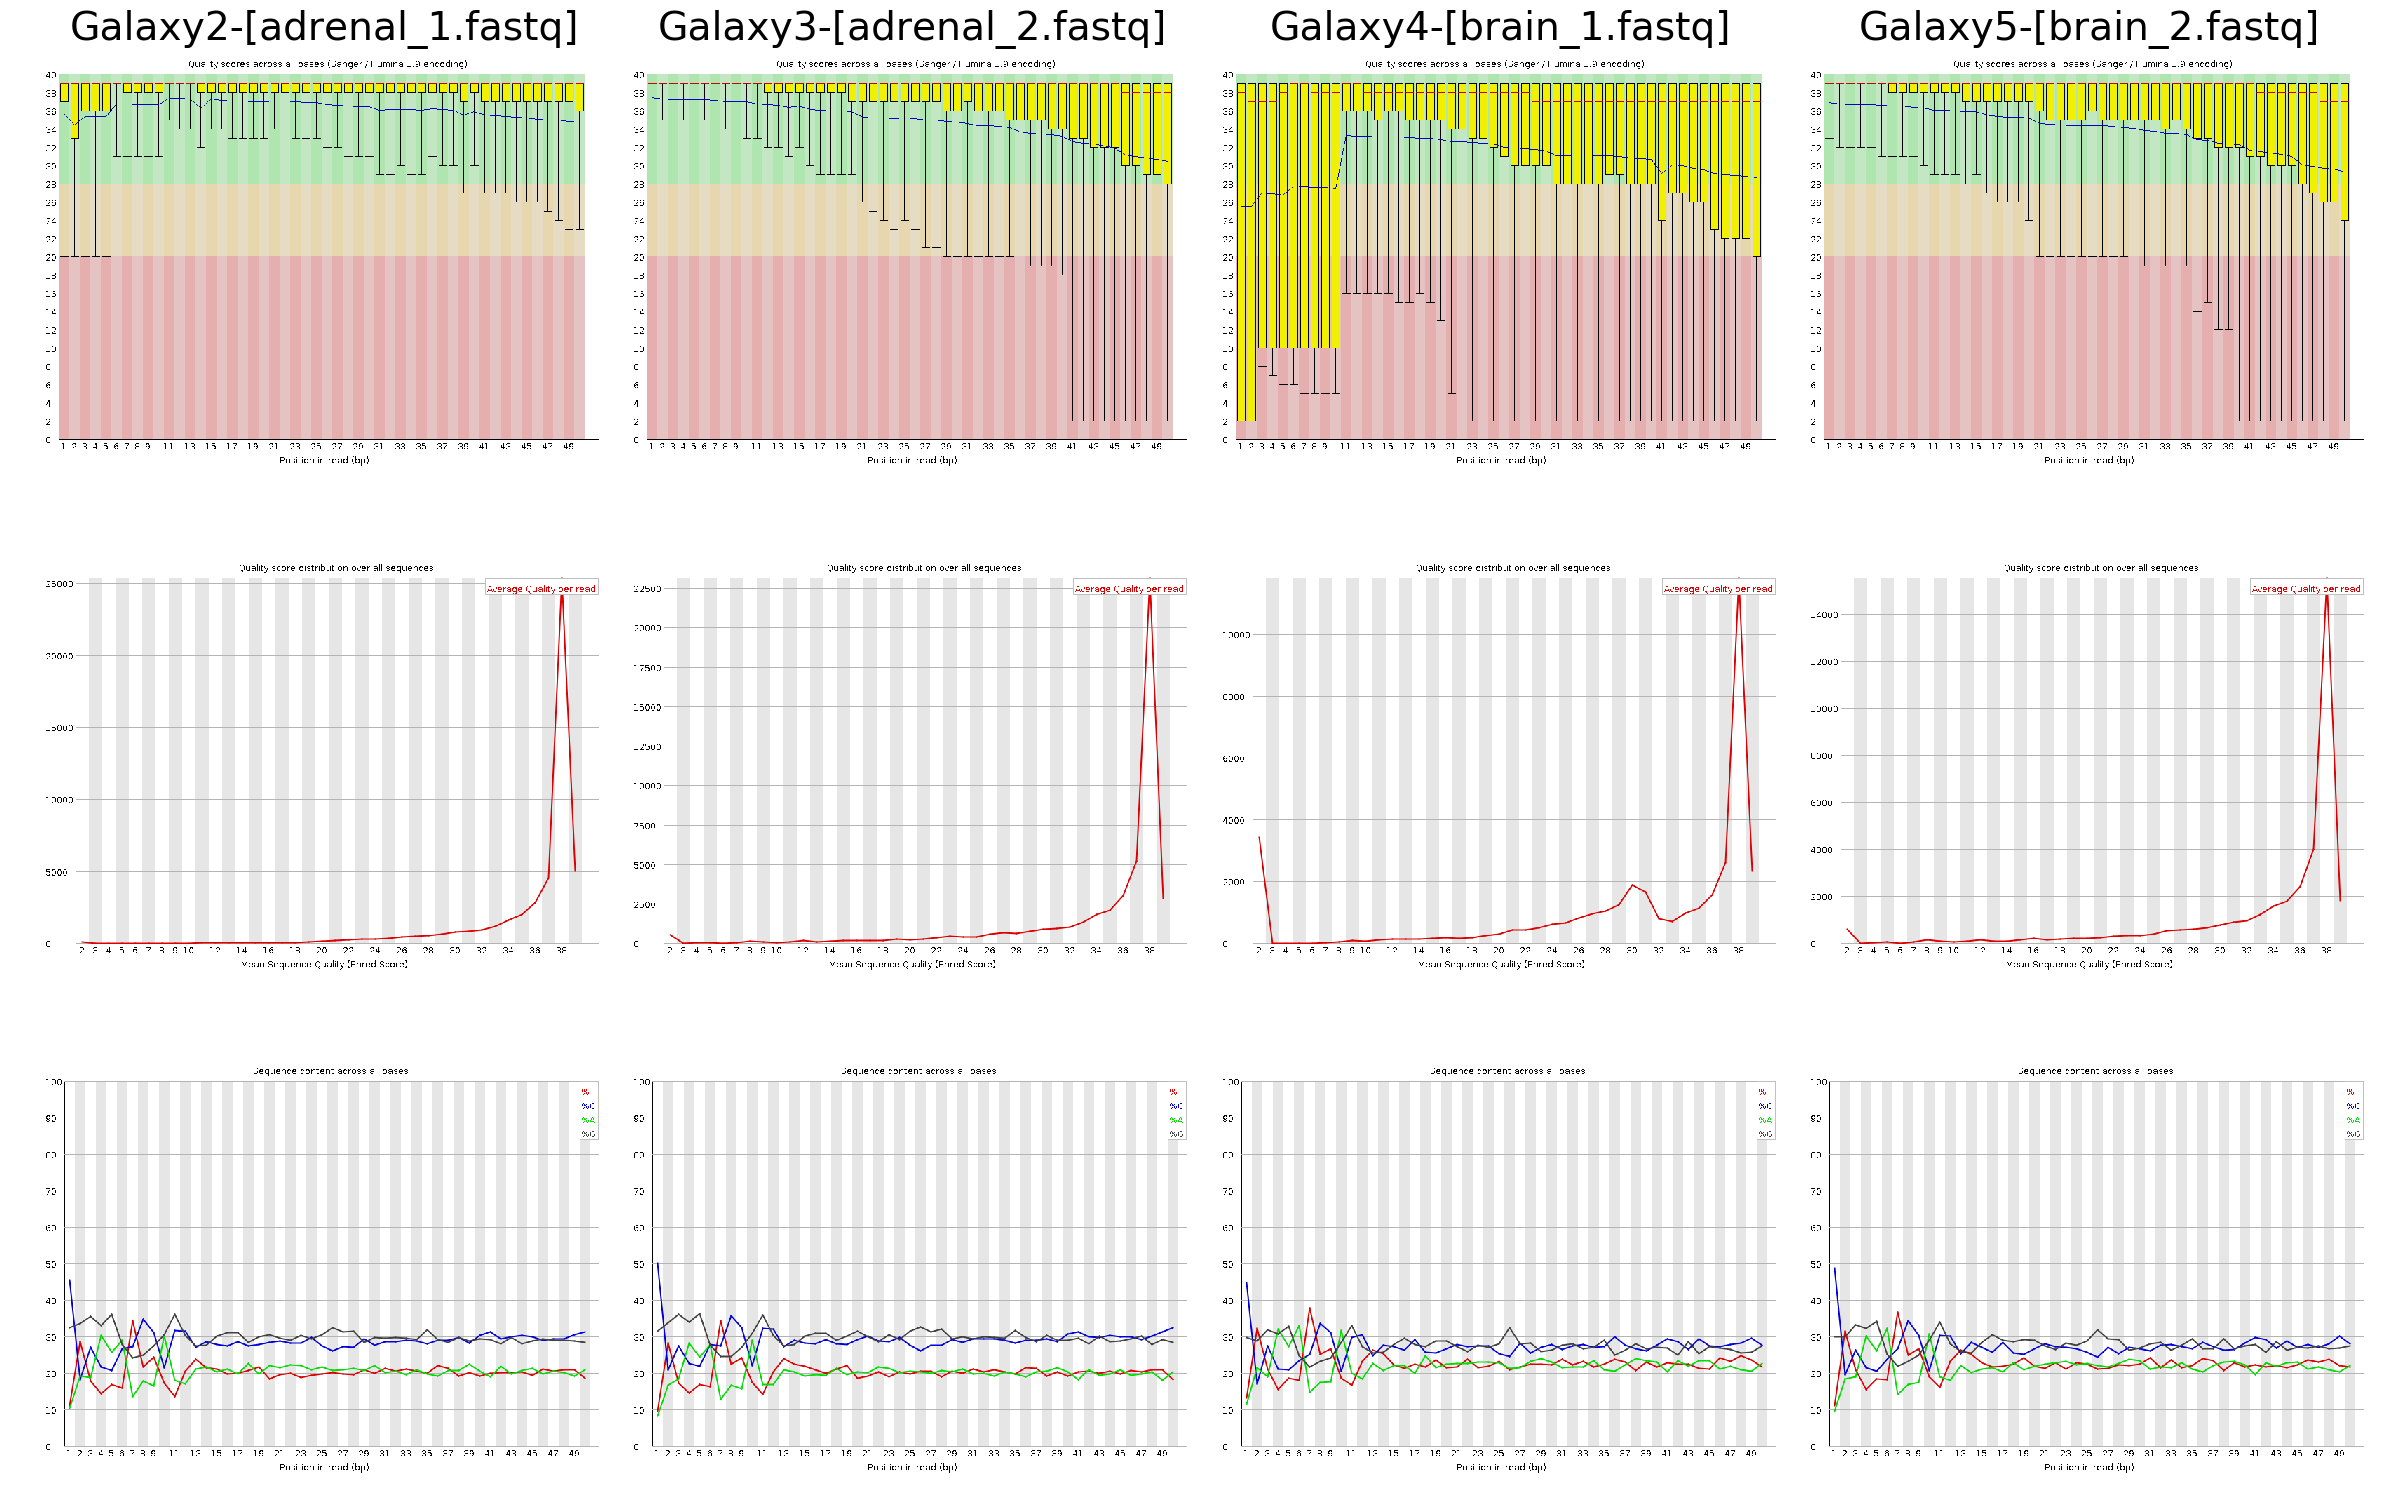

In [7]:
outer_dir = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq'
fastqc_plots = plot_fastqc(outer_dir)

<font color='red'>Note: It's really strange; I had originally designed the `plot_fastqc` function to yield 4 graphs, but whether I try '`kmer_profiles`' or '`duplication_levels`' as the final field, it always returns an error; either about the key (which would be the same dict key as in the previous 3 fields) or saying '`Nonetype has no attribute 'update'`'.  I copied and pasted the code that generates that key for each of the '`elif`' statements, so there's no reason it could have gone wrong.  I think there's something wrong with Python or IPython.  In any case, for now, rather than re-working it, I'm just going to omit the fourth graph and move on.</font color='red'>

Plotting them this way makes the graphs a little small, but it is at least possible to see the overall trends.  For instance, the 'Galaxy4' run was particularly poor, especially for the first 10 bases.

Another option is to take the FastQC output '`data.txt`' file for each FastQ file, parse the info inside, and re-plot in Matplotlib.  Actually, that's kind of ugly, since the FastQ file just returns summary stats (mean, median, quartiles), rather than raw data, and matplotlib box plots are calculated from raw data.  You could fudge the summary stats into a form plottable by matplotlib, but it seems like extra work.

As an alternative, at this point, I feel like switching over to [BioPython](http://biopython.org/DIST/docs/api/Bio.SeqIO.QualityIO-module.html), rather than carrying through Trimmomatic.  We'll see how that goes.

In [8]:
from Bio import SeqIO
import pandas as pd
import os
import numpy as np

start_dir_PC = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq'
start_dir_Mac = '/Users/drew/Documents/Data/Python/Galaxy_rnaseq/'

def parse_fastq(start_dir):
    biopy_fastqs = {}
    for file in os.listdir(start_dir):
        if file.split(sep='.')[-1] == 'fastqsanger':
            name = file.split(sep='.')[0]+']'
            file_path = os.path.join(start_dir, file)
            biopy_fastqs[name] = {}
            biopy_fastqs[name].update({'path': os.path.join(start_dir, file),
                                       'seqs': []})
            for record in SeqIO.parse(file_path, "fastq"):
                biopy_fastqs[name]['seqs'].append({'id': record.id, 
                                                   'sequence': np.array(list(str(record.seq))),
                                                   'quality': np.array(record.letter_annotations['phred_quality'])})
            biopy_fastqs[name]['df'] = pd.DataFrame.from_dict(biopy_fastqs[name]['seqs'])
    return biopy_fastqs

In [9]:
# biopy_fastqs = parse_fastq(start_dir_Mac)
biopy_fastqs = parse_fastq(start_dir_PC)

biopy_fastqs['Galaxy2-[adrenal_1]']['df'].head()

,id,quality,sequence
0,ERR030881.107,"[20, 13, 20, 19, 19, 11, 19, 19, 19, 18, 19, 1...","[A, T, C, T, T, T, T, G, T, G, G, C, T, A, C, ..."
1,ERR030881.311,"[38, 37, 37, 37, 38, 37, 37, 33, 37, 34, 39, 3...","[T, C, C, A, T, A, C, A, T, A, G, G, C, C, T, ..."
2,ERR030881.1487,"[20, 20, 9, 6, 10, 5, 5, 20, 6, 20, 20, 7, 6, ...","[G, T, A, T, A, A, C, G, C, T, A, G, A, C, A, ..."
3,ERR030881.9549,"[35, 27, 31, 35, 35, 32, 31, 32, 25, 32, 39, 3...","[A, A, C, G, G, A, T, C, C, A, T, T, G, T, T, ..."
4,ERR030881.13497,"[37, 31, 37, 37, 37, 38, 38, 37, 38, 37, 39, 3...","[G, C, T, A, A, T, C, C, G, A, C, T, T, C, T, ..."


In [10]:
biopy_fastqs['Galaxy2-[adrenal_1]']['seqs'][:2]

[{'id': 'ERR030881.107',
  'quality': array([20, 13, 20, 19, 19, 11, 19, 19, 19, 18, 19, 19, 20, 20, 20, 34, 34,
         30, 34, 32, 36, 37, 31, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37,
         37, 37, 37, 37, 37, 37, 37, 37, 36, 37, 37, 37, 36, 37, 37, 37]),
  'sequence': array(['A', 'T', 'C', 'T', 'T', 'T', 'T', 'G', 'T', 'G', 'G', 'C', 'T',
         'A', 'C', 'A', 'G', 'T', 'A', 'A', 'G', 'T', 'T', 'C', 'A', 'A',
         'T', 'C', 'T', 'G', 'A', 'A', 'G', 'T', 'C', 'A', 'A', 'A', 'A',
         'C', 'C', 'A', 'A', 'C', 'C', 'A', 'A', 'T', 'T', 'T'], dtype='<U1')},
 {'id': 'ERR030881.311',
  'quality': array([38, 37, 37, 37, 38, 37, 37, 33, 37, 34, 39, 39, 39, 39, 39, 39, 39,
         39, 39, 39, 40, 39, 36, 36, 36, 31, 31, 31, 28, 38, 39, 38, 39, 39,
         39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]),
  'sequence': array(['T', 'C', 'C', 'A', 'T', 'A', 'C', 'A', 'T', 'A', 'G', 'G', 'C',
         'C', 'T', 'C', 'G', 'G', 'G', 'G', 'T', 'G', 'G', 'G', 'G', '

Interestingly, on the Mac, that generates an error (warning?) about the IOPub data rate being exceeded.  The notebook server docs output suggests setting a flag upon launching the server, which sounds like a pain.  I found [this suggestion](https://stackoverflow.com/a/43420383) about changing a config file.  I'll try that now.

    $ jupyter notebook --generate-config
    Writing default config to: /Users/drew/.jupyter/jupyter_notebook_config.py
    $ sudo nano /Users/drew/.jupyter/jupyter_notebook_config.py

Searched and found (line 155):

    \# c.NotebookApp.iopub_data_rate_limit = 1000000
    
So I just added a line below it without the comment char, and with one more zero:

    c.NotebookApp.iopub_data_rate_limit = 10000000
    
That appears to work; I don't get the warning now.

In [11]:
df1 = biopy_fastqs['Galaxy2-[adrenal_1]']['df']

df1.shape

(50121, 3)

In [12]:
df1.iloc[:2, 1].as_matrix()

array([array([20, 13, 20, 19, 19, 11, 19, 19, 19, 18, 19, 19, 20, 20, 20, 34, 34,
       30, 34, 32, 36, 37, 31, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 37, 37, 36, 37, 37, 37, 36, 37, 37, 37]),
       array([38, 37, 37, 37, 38, 37, 37, 33, 37, 34, 39, 39, 39, 39, 39, 39, 39,
       39, 39, 39, 40, 39, 36, 36, 36, 31, 31, 31, 28, 38, 39, 38, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39])],
      dtype=object)

What I'm looking for here is a quick way to iterate over the rows of this series, and create a new array with the same index of each row as a new row, etc.  Or else, split them out into individual arrays, then perform a transpose operation and recombine them.  A good start is just to check out the numpy array methods [available](https://docs.scipy.org/doc/numpy/reference/routines.array-manipulation.html).

[Reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) might be suitable, maybe while specifying '`order="F"`'?  The problem there is that I don't know how to specify the '`newshape`' arg.  The array should have a shape of 50121 rows, 1 column, and each element in each cell is another array with shape (1, 50).  I guess it's actually listed '`(50,)`'.

[hstack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack)/[vstack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html#numpy.vstack)?

Ok, I think I've got it now; vstack then transpose seems to work.  The problem appears to be that having a numpy array where each element within is itself an array is not the same as having a multidimensional numpy array.  That is, nested arrays are not quite the same thing as a contiguous array.  I guess.

See below for a demonstration of how Python interprets some of these structures.  I don't fully understand it myself, but I knew that there must be a builtin method to flatten and then rearrange the data without using a '`for`' loop.

In [13]:
q1 = df1.iloc[:, 1]

print('1\t', type(q1), q1.shape)
print('2\t', type(q1), q1.shape)
print('3\t', type(np.vstack(q1)), np.vstack(q1).shape, '\n')

print('4\t', type(q1.as_matrix()), q1.as_matrix().shape)
print('5\t', type(np.vstack(q1.as_matrix())), '\n')

print('6\t', q1.as_matrix()[:2], '\n')
print('7\t', np.vstack(q1.as_matrix()[:2]), '\n')
print('8\t', np.vstack(q1.as_matrix()[:2]).T[:5], '\n')

print('9\t', type(q1.as_matrix()[0]), q1.as_matrix()[0].shape)
print('10\t', type(q1[0]), q1[0].shape)

# The line below yields AttributeError: 
# 'numpy.ndarray' object has no attribute 'as_matrix'
# print('10\t', type(np.vstack(q1.as_matrix()[0])), np.vstack(q1[0].as_matrix()[0]).shape)

1	 <class 'pandas.core.series.Series'> (50121,)
2	 <class 'pandas.core.series.Series'> (50121,)
3	 <class 'numpy.ndarray'> (50121, 50) 

4	 <class 'numpy.ndarray'> (50121,)
5	 <class 'numpy.ndarray'> 

6	 [array([20, 13, 20, 19, 19, 11, 19, 19, 19, 18, 19, 19, 20, 20, 20, 34, 34,
       30, 34, 32, 36, 37, 31, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 37, 37, 36, 37, 37, 37, 36, 37, 37, 37])
 array([38, 37, 37, 37, 38, 37, 37, 33, 37, 34, 39, 39, 39, 39, 39, 39, 39,
       39, 39, 39, 40, 39, 36, 36, 36, 31, 31, 31, 28, 38, 39, 38, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39])] 

7	 [[20 13 20 19 19 11 19 19 19 18 19 19 20 20 20 34 34 30 34 32 36 37 31 36
  36 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 36 37 37 37 36 37
  37 37]
 [38 37 37 37 38 37 37 33 37 34 39 39 39 39 39 39 39 39 39 39 40 39 36 36
  36 31 31 31 28 38 39 38 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
  39 39]] 

8	 [[20 38]
 [13 37]
 [20 

In [14]:
type(q1)

pandas.core.series.Series

So if I **can** get them in that format, the question now is the best way to build that into the existing function or add a new function.  I suppose that ultimately the best way to handle this is to make it a class, but I'm still not that up on building those.  

The 'per_base' scores are attributes of the entire FastQ file, not any particular sequence within it, so I'll put them in the higher-level dict first, then copy to the df.  The ones I might care about are 'per_base_quality', 'per_base_sequence_content', and 'per_base_N_content'.

...Actually, that might not work well.  The higher-order dict entries are all distinct entities for which there's no obvious 'round-these-all-up-in-numpy' function.  I might have to filter it through `pandas` anyway, to be able to get them out as a '`to_matrix()`' kind of functionality.  Note: there probably should be a way to pass the sequence elements from the dict iteratively into a new array (perhaps using the [`fromiter` method](https://stackoverflow.com/a/2648925)) before breaking them out into a single multidimensional array and transposing, but rather than learn about that I'll just try building the dataframe first, then using that to get the combined arrays.  It's still the case that the output should be stored in the dict associated with each FastQ file, however; attempting to append these values to the pandas DF fails because the length of the DF's index doesn't match the length of the transposed array of '`per_base`' scores.

* For per_base_N_content, I want to take the vstack().T array and, per row in the array, output a count of just 'N' values.  It sounds like the [`numpy.where()`](https://docs.scipy.org/doc/numpy/reference/routines.sort.html) method might be best for that.  Alternatively, maybe [np.unique()](https://stackoverflow.com/a/28663910)?  

    * As [this](https://stackoverflow.com/a/34667386) post points out, the behavior of `np.where()` is, if the input array is 2D, as here, to output two arrays: the first contains a list of all rows where the condition is met, the second contains a list of all columns where the condition is met.

    * The two output arrays of `np.where()` should therefore be the exact same shape, a tuple of form '(x, )', where x is equal to the exact count of how many times the condition was met.  
    
    * From that understanding, there's really no need to convert the sequence array into a per-base-seq array using the whole `vstack().T` approach.  It should suffice to take the sequence of an entire FastQ file as an array, where each row is a read and each column is a position from 0 to 50 within each read, feed it through `np.where()`, take the second array of its output, which gives column values, then count how often each int appears, and plot that.
    
    * Actually, the approach listed in the bullet point immediately above sounds unnecessarily complex.  It should be easier to combine '`np.vstack()`' with '`np.unique( , return_counts=True, axis=1)`'... but for some reason that keeps the elements all separate; it outputs in an unexpected format.  I see now that I was using '`np.nditer()`', and by taking a closer look at [these docs](https://docs.scipy.org/doc/numpy/reference/arrays.nditer.html#arrays-nditer), I see that that method is meant not to iterate over just rows within an array, but over **individual values**.  It looks like numpy is still meant to use `for` loops to iterate over entire rows within an array.

* For per_base_sequence_content, I'll probably want a variant of the same output: the `where()` method might work.

* For per_base_quality, I can just leave the scores as is, then call a box-and-whiskers plot on them later.

The only 'per_sequence' score that I might want is probably 'per_sequence_quality' (average quality per read).

Actually, for each FastQ file, I'd also like to know how many duplicates are present; that seems like potentially useful info.  Since these files are RNAseq data, and may represent truly useful info about sequence abundance in the original sample, I probably won't end up deleting duplicates, but it still seems like important info to track.  The interpretation of the equivalent example from FastQC is [a tad nuanced](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/8%20Duplicate%20Sequences.html), but I think I can get through it.

The raw value_counts are not super graph-friendly, because of how large the number of one-offs are present; I could try log-log scales (or semi-log), but FastQC's choice of bins of 1-10, 50, 500, and 5,000 counts might be a good format to copy.  As such, the [pandas.cut()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html) method would be a convenient way to apply them.

In [15]:
from Bio import SeqIO
import pandas as pd
import os
import numpy as np
from collections import defaultdict

start_dir_PC = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq'
start_dir_Mac = '/Users/drew/Documents/Data/Python/Galaxy_rnaseq/'

def parse_fastq(start_dir):
    biopy_fastqs = {}
    phred_scale = 39   # Assuming Illumina data; change if diff qual score scale
    for file in os.listdir(start_dir):
        if file.split(sep='.')[-1] in ['fastqsanger', 'fastq']:
            name = file.split(sep='.')[0]+']'
            file_path = os.path.join(start_dir, file)
            biopy_fastqs[name] = {}
            biopy_fastqs[name].update({'path': os.path.join(start_dir, file),
                                       'seqs': []})
            for record in SeqIO.parse(file_path, "fastq"):
                biopy_fastqs[name]['seqs'].append({'id': record.id, 
                                                   'sequence': np.array(list(str(record.seq))),
                                                   'seq_whole': str(record.seq),
                                                   'quality': np.array(record.letter_annotations['phred_quality'])})
                
            biopy_fastqs[name]['df'] = pd.DataFrame.from_dict(biopy_fastqs[name]['seqs'])
            biopy_fastqs[name]['per_base_qual'] = np.vstack(biopy_fastqs[name]['df']['quality']).T
            biopy_fastqs[name]['per_base_seq'] = np.vstack(biopy_fastqs[name]['df']['sequence']).T
            
            # Count base calls to dicts; one for raw counts, one for percentages:
            biopy_fastqs[name]['per_base_counts'] = []
            biopy_fastqs[name]['per_base_percents'] = []
            
            for i, row in enumerate(biopy_fastqs[name]['per_base_seq']):
                biopy_fastqs[name]['per_base_counts'].append(defaultdict())
                unique, counts = np.unique(row, return_counts=True)
                biopy_fastqs[name]['per_base_counts'][i] = dict(zip(unique, counts))
                
            for i, dictionary in enumerate(biopy_fastqs[name]['per_base_counts']):
                biopy_fastqs[name]['per_base_percents'].append(defaultdict())
                for k in dictionary.keys():
                    biopy_fastqs[name]['per_base_percents'][i][k] = dictionary[k] / sum(dictionary.values())
                        
            # Let's put the counts into a 'per_base_df':
            biopy_fastqs[name]['per_base_seq_df'] = pd.DataFrame.from_dict(
                biopy_fastqs[name]['per_base_counts']).fillna(value=0)
            biopy_fastqs[name]['per_base_percents_df'] = pd.DataFrame.from_dict(
                biopy_fastqs[name]['per_base_percents']).fillna(value=0)
            biopy_fastqs[name]['per_base_qual_df'] = pd.DataFrame(
                biopy_fastqs[name]['per_base_qual']).fillna(value=0)
            
            # add values for duplication level
            biopy_fastqs[name]['duplicates'] = biopy_fastqs[name]['df'].groupby(['seq_whole']).size()\
            .value_counts().sort_index()

            # add mean per_seq_qual
            biopy_fastqs[name]['mean_seq_qual'] = pd.cut(biopy_fastqs[name]['df']['quality'] \
                                                       .apply(np.mean), range(1, 41)).value_counts().sort_index()
            biopy_fastqs[name]['mean_seq_qual'].index = np.arange(2, phred_scale + 2)

            
    
    return biopy_fastqs

In [16]:
biopy_fastqs = parse_fastq(start_dir_PC)
# biopy_fastqs = parse_fastq(start_dir_Mac)

In [17]:
for x in biopy_fastqs:
    print(x)

print('\n')

for x in biopy_fastqs['Galaxy2-[adrenal_1]']: 
    print(x, type(biopy_fastqs['Galaxy2-[adrenal_1]'][x]))

Galaxy2-[adrenal_1]
Galaxy3-[adrenal_2]
Galaxy4-[brain_1]
Galaxy5-[brain_2]


path <class 'str'>
seqs <class 'list'>
df <class 'pandas.core.frame.DataFrame'>
per_base_qual <class 'numpy.ndarray'>
per_base_seq <class 'numpy.ndarray'>
per_base_counts <class 'list'>
per_base_percents <class 'list'>
per_base_seq_df <class 'pandas.core.frame.DataFrame'>
per_base_percents_df <class 'pandas.core.frame.DataFrame'>
per_base_qual_df <class 'pandas.core.frame.DataFrame'>
duplicates <class 'pandas.core.series.Series'>
mean_seq_qual <class 'pandas.core.series.Series'>


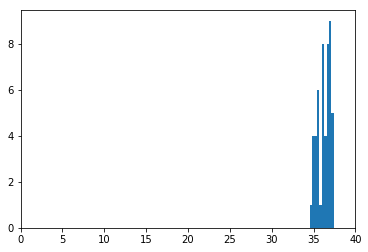

In [18]:
per_seq_qual = biopy_fastqs['Galaxy2-[adrenal_1]']['df']['quality'].mean()
plt.hist(per_seq_qual)
plt.xlim([0, 40])
plt.show()

In [19]:
biopy_fastqs['Galaxy2-[adrenal_1]']['per_base_seq_df'].head()

,A,C,G,N,T
0,5220,22899,16298,28.0,5676
1,9635,9188,16905,19.0,14374
2,9537,13661,17916,0.0,9007
3,15265,10913,16628,14.0,7301
4,13011,10464,18146,1.0,8499


In [20]:
biopy_fastqs['Galaxy2-[adrenal_1]']['per_base_percents_df'].head()

,A,C,G,N,T
0,0.104148,0.456874,0.325173,0.000559,0.113246
1,0.192235,0.183316,0.337284,0.000379,0.286786
2,0.190280,0.272560,0.357455,0.000000,0.179705
3,0.304563,0.217733,0.331757,0.000279,0.145667
4,0.259592,0.208775,0.362044,0.000020,0.169570


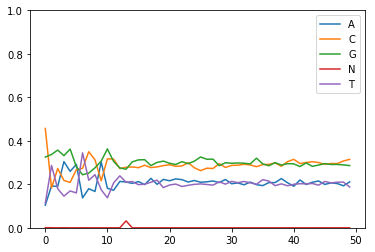

In [21]:
import matplotlib.pyplot as plt

biopy_fastqs['Galaxy2-[adrenal_1]']['per_base_percents_df'].plot()
plt.ylim([0, 1])
plt.show()

Now, put them together into a function.  I think I'm going to need [this](https://pandas.pydata.org/pandas-docs/stable/visualization.html#using-layout-and-targeting-multiple-axes) info.


In [22]:
import matplotlib.pyplot as plt

def plot_fastq(biopy_fastqs): 
    batches = int(np.ceil(len(biopy_fastqs) / 4))
    plt.close('all')
    plt.style.use('ggplot')
    my_dpi = 96
    fig_scale = 500
    # put at most 4 fastq files per row
    fig, axs = plt.subplots(nrows=5*batches, ncols=4, 
                            figsize=(4*fig_scale/my_dpi, 4*batches*fig_scale/my_dpi), 
                            dpi=my_dpi)

    for i, fastq_name in enumerate(sorted(biopy_fastqs)):
        batch = int(np.floor(i / 4))
        i2 = i % 4
        axs[batch, i%4].set_title(fastq_name, fontsize=fig_scale/25)
        axs[batch, 0].set_ylabel('Per base \nQuality', fontsize=fig_scale/25)
        axs[batch+1, 0].set_ylabel('Per base \nSequence \nContent', fontsize=fig_scale/25)
        axs[batch+2, 0].set_ylabel('Per base \nN Content', fontsize=fig_scale/25)
        axs[batch+3, 0].set_ylabel('Per Sequence \nMean Quality\nScore', fontsize=fig_scale/25)
        axs[batch+4, 0].set_ylabel('# of Seq. vs. \nDuplication \nLevel', fontsize=fig_scale/25)
        biopy_fastqs[fastq_name]['per_base_qual_df'].T.plot(kind='box', 
                                                            showfliers=False, 
                                                            ax=axs[0, i], 
                                                            sharey=True,
                                                            ylim=[0, 40])
        biopy_fastqs[fastq_name]['per_base_percents_df'].plot(kind='line', 
                                                              ax=axs[1, i],
                                                              sharey=True,
                                                              ylim=[0, 1])
        biopy_fastqs[fastq_name]['per_base_percents_df']['N'].plot(kind='line', 
                                                                   ax=axs[2, i],
                                                                   sharey=True,
                                                                   ylim=[0, 0.1])
        biopy_fastqs[fastq_name]['mean_seq_qual'].plot(kind='line',
                                                       ax=axs[3, i],
                                                       sharey=True)
        axs[3, i].set_ylim(top=12000)
#         axs[3, i].set_xticklabels(list(range(1, 41)))
#         axs[3, i].set_yscale('log')
        biopy_fastqs[fastq_name]['duplicates'].plot(kind='line',
                                              ax=axs[4, i],
                                              sharey=True)
        axs[4, i].set_xscale('log')
        axs[4, i].set_yscale('log')
        axs[4, i].set_ylim(bottom=0.5)
        


    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.show()

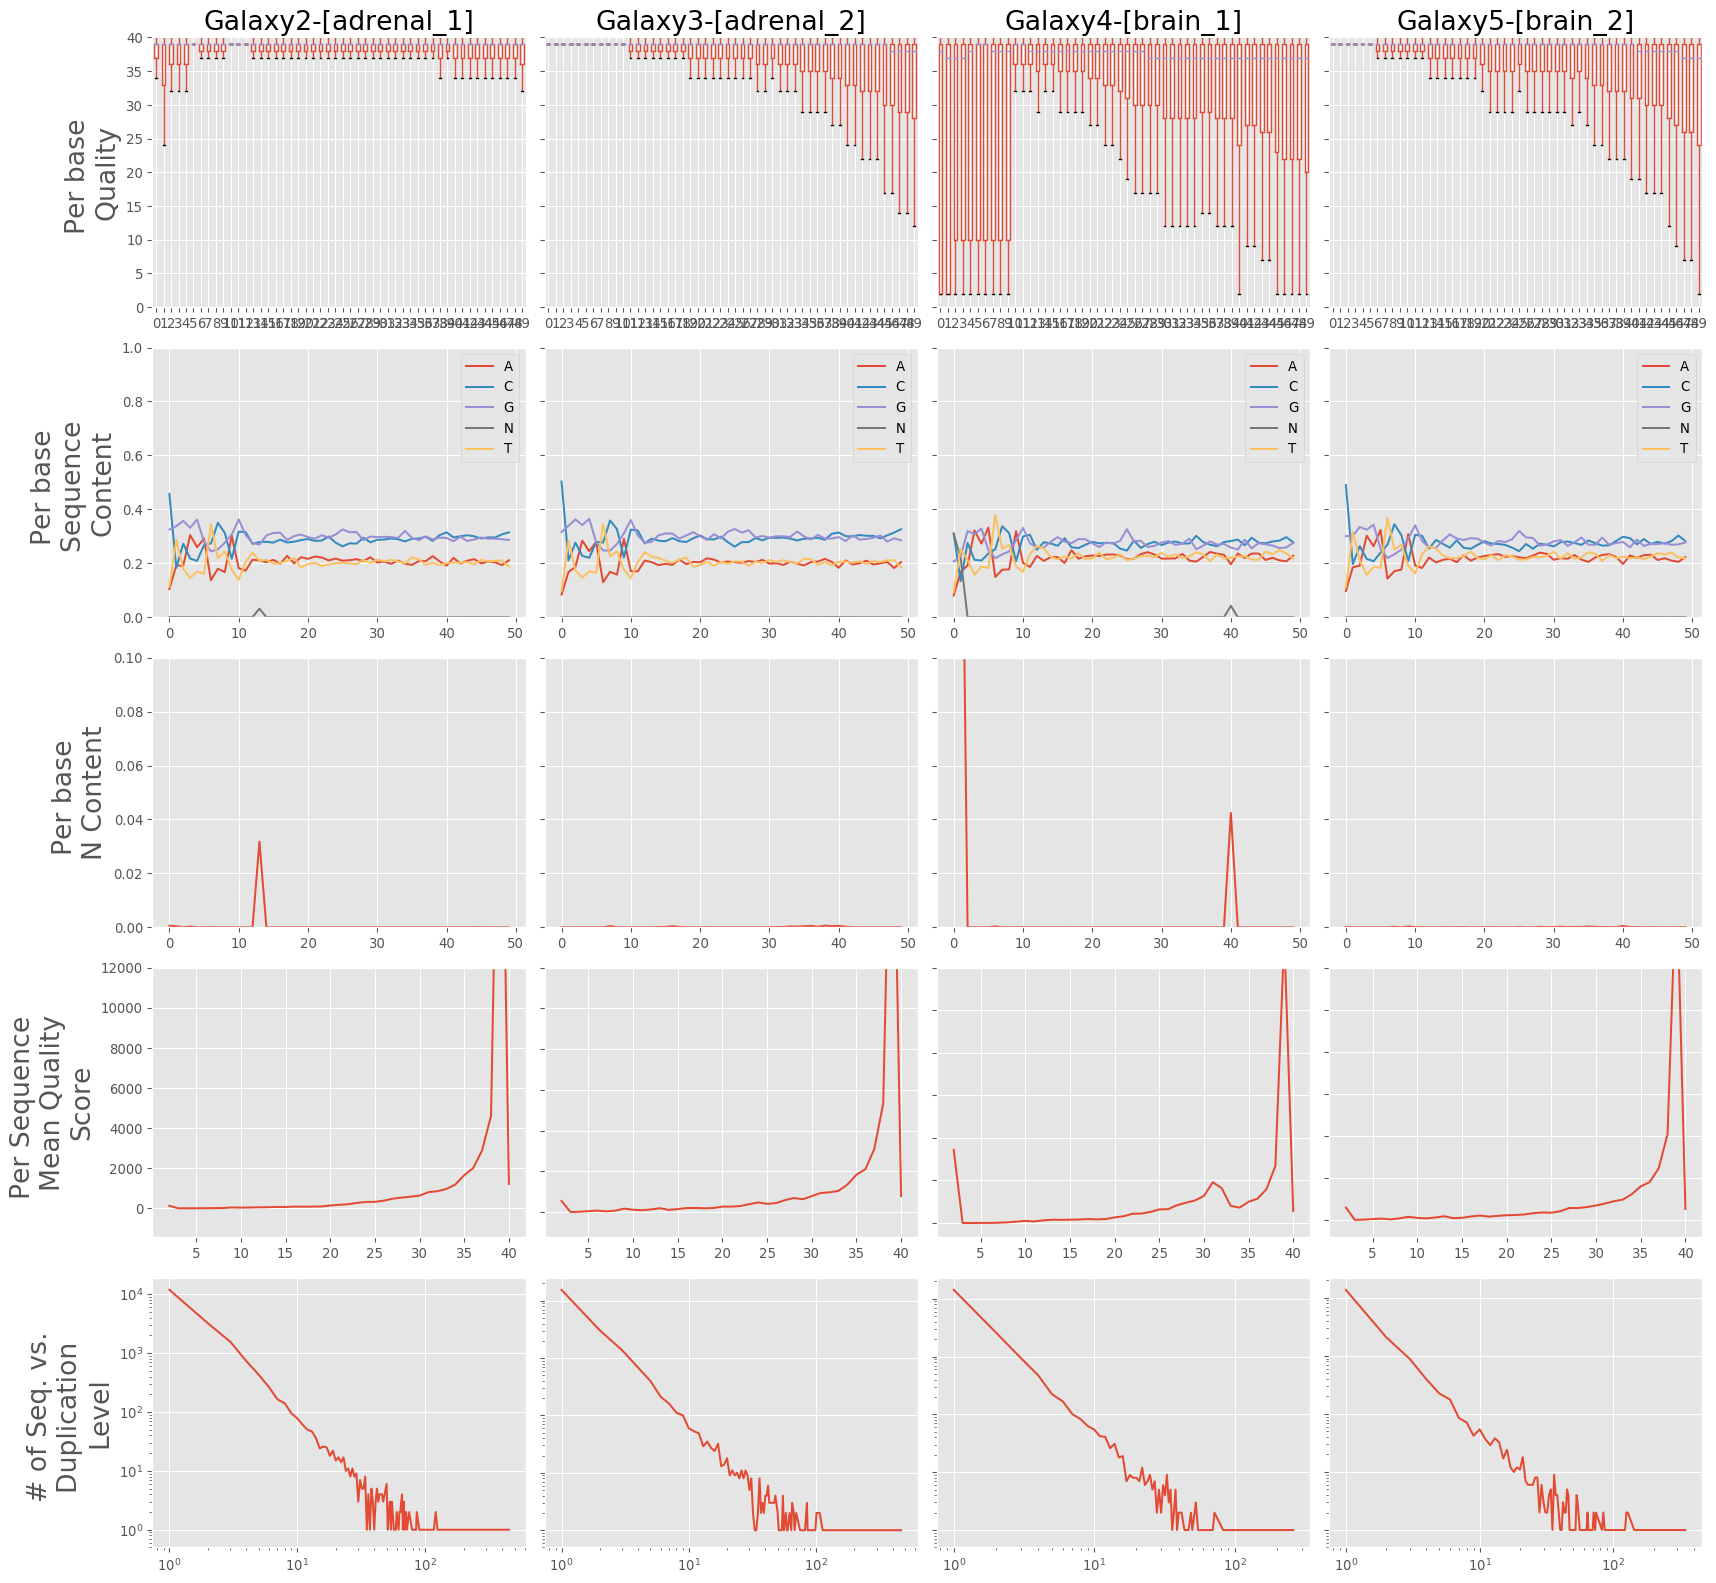

In [23]:
plot_fastq(biopy_fastqs)

I think that those results look pretty similar to the FastQC results, but just to be sure that I preserved the right relationships when applying the operations to calculate the per_base scores, I'd like to compare the summary statistics of the per_base_qual from BioPython to those output from the FastQC_data files:

In [24]:
# This cell to set-up comparison of per_base_qual stats
# derived from FastQC software to those from my biopython wrangling

from Bio import SeqIO
import pandas as pd
import os
import numpy as np
from collections import defaultdict

start_dir_PC = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq'
start_dir_Mac = '/Users/drew/Documents/Data/Python/Galaxy_rnaseq/'

def parse_fastqc_data(start_dir):
    fastqc_data = defaultdict()
    for root, subdirs, files in os.walk(start_dir):
        for file in files:
            if file == 'fastqc_data.txt':
                    name = os.path.split(root)[-1].split(sep='.')[0]+']'
                    fastqc_data[name] = {}
                    with open(os.path.join(root, file)) as f:
                        # Summary data for per_base_quality seems to be on lines 14-63
                        lines = [line.rstrip('\n') for line in f]
                        fastqc_data[name]['lines'] = []
                        for line in lines[13:63]:
                            fastqc_data[name]['lines'].append(line.split(sep='\t'))
                            
                    fastqc_data[name]['compare'] = pd.DataFrame()
                    fastqc_data[name]['compare']['biopy'] = \
                        biopy_fastqs[name]['per_base_qual_df'].T.mean(axis=0)
                    fastqc_data[name]['compare']['fastqc'] = \
                        [float(stats[1]) for stats in fastqc_data[name]['lines'][:]]
                    fastqc_data[name]['compare']['ratio'] = (
                        fastqc_data[name]['compare']['biopy'] / fastqc_data[name]['compare']['fastqc'])
            else:
                continue

    return fastqc_data

In [25]:
fastqc_data = parse_fastqc_data(start_dir_PC)

for name in fastqc_data:
    print(name, fastqc_data[name]['compare']['ratio'].describe())

Galaxy2-[adrenal_1] count    50.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: ratio, dtype: float64
Galaxy3-[adrenal_2] count    50.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: ratio, dtype: float64
Galaxy4-[brain_1] count    50.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: ratio, dtype: float64
Galaxy5-[brain_2] count    50.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: ratio, dtype: float64


Ok, that was a bit of overkill, but it shows definitively that the biopython-based wrangling of the data into per_base statistics gives the same result in all cases as does FastQC.

So at this point I've ensured that I can rearrange data from BioPython's SeqIO module that can gather the same summary stats as the FastQC tool, and I've gotten a decent overall view of the associated plots.  The problem is that the individual plots are a little too small within the IPython/Jupyter Notebook window to get all of the essential data out, so I'd like to generate an interactive plot that can enlarge individual subplots upon mousing over or clicking.  (As a more minor point, if > 4 `fastq` files are present in the host `dir`, you could end up with too many columns to read, no matter **how** big you make the window, so there should be a line to wrap the axes into columns of 4 for future use.)

This could end up being a bit too long an undertaking at this point; I may earmark it for future improvement.  Best bets for interactive visualization at this point appear to be [Bokeh](http://bokeh.pydata.org/en/latest/), which sounds like it's basically a Python wrapper for the D3.js (javascript-based) library, along with the associated tool [Holoviews](http://holoviews.org/), which sounds like it's mostly meant to simplify some of the gruntwork of setting up a visualization using tools like Bokeh.

Once the visualization is suitably handled, the next task is trimming.  As you can see from this example, the Galaxy2 reads are all pretty high quality, but some of the other runs are pretty bad.  In the past, after checking reads with FastQC, I've run them through the [Trimmomatic tool](http://www.usadellab.org/cms/?page=trimmomatic) to cut off parts of reads that don't reach a quality threshold.  Another option, to which I was directed from a forum discussing BioPython, is [sickle](https://github.com/najoshi/sickle); it's not native Python, however, so it probably wouldn't be any easier to use from within Python than Trimmomatic.

Actually, first it might be best to throw out entire reads if they're poor quality; such as those with a mean qual below, say, 30?  Then, trim individual bases by quality score from the reads that pass that filter.  When trimming, you obviously don't want to just delete the low-quality bases, since that may end up concatenating better bases on either side.  Rather, delete the offending base and all those 5' or 3' to it, depending on whether you're trimming from the 5' or 3' end, both of which tend to have a higher proportion of low quality scores, while the middle of the read is generally better.  I could define these as two different functions, one that reads progressively more 3' up to base #25, and one that starts at the 3' end and reads upstream until the midpoint of the read, as well.

Finally, since tiny reads are likely to map to multiple reference sequences ambiguously, I'd want to throw out any reads that were too short after trimming for quality.  Say, <35bp in length.

When it comes to deciding upon quality cutoffs, length cutoffs, and other such important scores to decide in the trimming process, I find [Biostars](https://www.biostars.org/p/195903/) to be the website with the most useful discussions.

Actually, there's one more factor that I've been overlooking: these reads are from a paired-end dataset.  I don't have any easy way to handle that in BioPython right now.  Maybe I should stop re-inventing the wheel with this analysis and just bring in some other bioinformatics packages.

Trimmomatic expects paired reads to be fed in as separate files.  Though I've been ignoring the biological details of the derivation of these data sets, it would appear that we in fact have two different sets of paired end reads from two separate libraries with these four files: the first few reads in Galaxy2's identifiers match that of Galaxy3; Galaxy2's have the '`/1`' suffix, and Galaxy3's have the '`/2`', so the order is what you'd expect.

Therefore, I can process these with Trimmomatic directly.  I could write a Python-based pipeline to execute this, but that might be awkward given the need to switch to the Unix shell.  Eh, I'll try it.

---

<font color='red'>Note: on the PC, I tried 'sudo apt-get install trimmomatic' in the Ubuntu shell window, and got:
<br /><br />
Selecting previously unselected package trimmomatic.<br />
(Reading database ... 27039 files and directories currently installed.)<br />
Preparing to unpack .../trimmomatic_0.35+dfsg-1_all.deb ...<br />
Unpacking trimmomatic (0.35+dfsg-1) ...<br />
Processing triggers for man-db (2.7.5-1) ...<br />
Setting up trimmomatic (0.35+dfsg-1) ...<br /><br />

as output.  Checking the expected (default) install dir, I find the executable at: <br /><br />
/usr/bin/TrimmomaticPE</font>

---

Example input for PE:

    java -jar trimmomatic-0.35.jar PE -phred33 input_forward.fq.gz input_reverse.fq.gz output_forward_paired.fq.gz output_forward_unpaired.fq.gz output_reverse_paired.fq.gz output_reverse_unpaired.fq.gz ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

In [26]:
import sys, os

def trimmomatic_paired(biopy_fastqs, mac_pc='mac', **kwargs):
    
    # Set the path for trimmomatic based on which laptop I'm using
    rand_entry = list(biopy_fastqs.keys())[0]
    if mac_pc == 'mac':
        trim_path = '/Users/drew/Documents/Data/Bio/\
Trimmomatic-0.36/trimmomatic-0.36.jar'
        commands = []
        wd = os.path.dirname(biopy_fastqs[rand_entry]['path'])
        sep = ';'
    elif mac_pc == 'pc':
        trim_path = r'C:\Users\DMacKellar\Documents\Python\\
BioPython\Trimmomatic-0.36\trimmomatic-0.36.jar'
        commands = []
        wd = os.path.dirname(biopy_fastqs[rand_entry]['path'])
        sep = ' & '
    else:
        print('Please specify "mac_pc" arg as "mac" or "pc"')
    
    adapter_path = os.path.join(os.path.dirname(trim_path), 'adapters')
    # Confirm that the file exists
    try:
        os.path.isfile(trim_path)
    except:
        print('trimmomatic.jar file not found at expected location')
        sys.exit(1)   # abort the function
    
    # Confirm that the input dict 
    # contains an even number of fastq files
    try:
        len(biopy_fastqs) % 2 != 0
    except:
        print('Input has odd number of fastq files; \
\nPlease enter paired end data.')
        sys.exit(1)   # abort the function
        
    use_kwargs = {}
    
    # Specify valid kwarg keys and default values
    default_kwargs = {
        'phred': '-phred33',
        'ILLUMINACLIP': '',
        'LEADING': 'LEADING:25',
        'TRAILING': 'TRAILING:25',
        'SLIDINGWINDOW': '',
        'MINLEN': 'MINLEN:35'
    }
    
    # For any input kwargs, pass them to the use_kwargs dict
    for key, value in kwargs.items():
        if key in default_kwargs:
            use_kwargs[key] = value
            if (key=='ILLUMINACLIP') & (value != ''):
                illclip_split = value.split(sep=':')
                adapter_file = os.path.join(adapter_path,
                                            illclip_split[1])
                try:
                    os.path.isfile(adapter_file)
                    illclip_join = ':'.join((illclip_split[0],
                                             adapter_file,
                                             *(x for x in illclip_split[2:])))
                    use_kwargs['ILLUMINACLIP'] = illclip_join
                except OSError as err:
                    print('Adapter file {0} not found.'.format(adapter_file))
                    sys.exit(1)   # abort the function

        else:
            print('kwarg key, value pair: {0}: {1} not understood;\
please specify key in (case-sensitive) manner.\
Default kwargs are: {3}'.format(key,
                                value,
                                default_kwargs))
    
    # Initialize some default settings in case none specified
    for key, value in default_kwargs.items():
        if key not in use_kwargs:
            use_kwargs[key] = value
            
    print('kwarg key, value pairs used: ', use_kwargs)
        
    # Format and output the relevant commands
    fastq_files = [x for x in sorted(biopy_fastqs)]
    fastq_paths = [biopy_fastqs[x]['path'] 
                   for x in sorted(biopy_fastqs)]
    forwards = fastq_files[0::2]
    forward_paths = fastq_paths[0::2]
    reverses = fastq_files[1::2]
    reverse_paths = fastq_paths[1::2]
    
    for f, f_p, r, r_p in zip(forwards, forward_paths, reverses, reverse_paths):
        trim_commands = ['java -jar', trim_path, 'PE', use_kwargs['phred'],
                        use_kwargs['ILLUMINACLIP'], use_kwargs['LEADING'], 
                        use_kwargs['TRAILING'], use_kwargs['SLIDINGWINDOW'], 
                        use_kwargs['MINLEN']]
        os.chdir(wd)
        to_insert = [f_p, r_p, '%s_trimmed_paired.fastq' % f,
                     '%s_trimmed_unpaired.fastq' % f, 
                     '%s_trimmed_paired.fastq' % r, 
                     '%s_trimmed_unpaired.fastq' % r]
        for i, thing in enumerate(to_insert):
            trim_commands.insert(3+i, thing)

        trim_commands = ' '.join(trim_commands)
        commands.append(trim_commands)
        
    commands = sep.join(commands)
        
    return commands

In [27]:
str.join?

In [28]:
commands = trimmomatic_paired(biopy_fastqs, mac_pc='mac')
commands

kwarg key, value pairs used:  {'phred': '-phred33', 'ILLUMINACLIP': '', 'LEADING': 'LEADING:25', 'TRAILING': 'TRAILING:25', 'SLIDINGWINDOW': '', 'MINLEN': 'MINLEN:35'}


'java -jar /Users/drew/Documents/Data/Bio/Trimmomatic-0.36/trimmomatic-0.36.jar PE C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\Galaxy2-[adrenal_1.fastq].fastqsanger C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\Galaxy3-[adrenal_2.fastq].fastqsanger Galaxy2-[adrenal_1]_trimmed_paired.fastq Galaxy2-[adrenal_1]_trimmed_unpaired.fastq Galaxy3-[adrenal_2]_trimmed_paired.fastq Galaxy3-[adrenal_2]_trimmed_unpaired.fastq -phred33  LEADING:25 TRAILING:25  MINLEN:35;java -jar /Users/drew/Documents/Data/Bio/Trimmomatic-0.36/trimmomatic-0.36.jar PE C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\Galaxy4-[brain_1.fastq].fastqsanger C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\Galaxy5-[brain_2.fastq].fastqsanger Galaxy4-[brain_1]_trimmed_paired.fastq Galaxy4-[brain_1]_trimmed_unpaired.fastq Galaxy5-[brain_2]_trimmed_paired.fastq Galaxy5-[brain_2]_trimmed_unpaired.fastq -phred33  LEADING:25 TRAILING:25  MINLEN:35

I copied the command above to the terminal on my Mac.  It ran quickly, and output:

    /Users/drew/Documents/Data/Python/Galaxy_rnaseq/Galaxy2-[adrenal_1.fastq].fastqsanger /Users/drew/Documents/Data/Python/Galaxy_rnaseq/Galaxy3-[adrenal_2.fastq].fastqsanger Galaxy2-[adrenal_1]_trimmed_paired.fastq Galaxy2-[adrenal_1]_trimmed_unpaired.fastq Galaxy3-[adrenal_2]_trimmed_paired.fastq Galaxy3-[adrenal_2]_trimmed_unpaired.fastq -phred33 LEADING:25 TRAILING:25 MINLEN:35
    Multiple cores found: Using 2 threads
    Input Read Pairs: 50121 Both Surviving: 45162 (90.11%) Forward Only Surviving: 3074 (6.13%) Reverse Only Surviving: 1163 (2.32%) Dropped: 722 (1.44%)
    TrimmomaticPE: Completed successfully
    TrimmomaticPE: Started with arguments:
     /Users/drew/Documents/Data/Python/Galaxy_rnaseq/Galaxy4-[brain_1.fastq].fastqsanger /Users/drew/Documents/Data/Python/Galaxy_rnaseq/Galaxy5-[brain_2.fastq].fastqsanger Galaxy4-[brain_1]_trimmed_paired.fastq Galaxy4-[brain_1]_trimmed_unpaired.fastq Galaxy5-[brain_2]_trimmed_paired.fastq Galaxy5-[brain_2]_trimmed_unpaired.fastq -phred33 LEADING:25 TRAILING:25 MINLEN:35
    Multiple cores found: Using 2 threads
    Input Read Pairs: 37992 Both Surviving: 29529 (77.72%) Forward Only Surviving: 2097 (5.52%) Reverse Only Surviving: 5045 (13.28%) Dropped: 1321 (3.48%)
    TrimmomaticPE: Completed successfully
    
When I try copy-paste-running the above on the PC, however, I get the error:

    Error: Invalid or corrupt jarfile /usr/bin/TrimmomaticPE
    
After Googling, I came across a post from my old collaborator Tony Bolger, saying that I need to add something about a partial URL of the source from which the program was obtained; something that I seem to remember seeing in my notes while I was at Harvard:

    java -classpath <path to trimmomatic jar> org.usadellab.trimmomatic.TrimmomaticPE
    
Unfortunately, it seems that the executable at '`/usr/bin/TrimmomaticPE`' isn't the right file to pass in place of the '`<path to trimmomatic jar>`' placeholder in the command above.  Since I used '`apt-get install trimmomatic`' to get the program on my PC, I didn't know the actual location where that jar file could be found.  So I went to root and used find:

    cd /
    sudo find . -name "*trimmomatic*jar"
    
That took a while to run because it scanned through all of the Windows-specific dirs, outputting '`permission denied`' for tons of dirs, because the Ubuntu-specific password doesn't work for the Windows-controlled sectors of the hard drive.  Anyways, it eventually found the jar file in:

    ./usr/share/java/trimmomatic-0.35.jar
    
But when I tried running that, it wanted the commands in a sufficiently different format that it would've been a pain in the ass to reprogram the whole function.  Instead, I just chose to uninstall the distro I got with '`apt-get install`', and grab the zip file from [the same source as on the Mac](http://www.usadellab.org/cms/uploads/supplementary/Trimmomatic/Trimmomatic-0.36.zip).  I put the zip file under the home dir in the Ubuntu structure; the jar will be at '`~/Documents/BioPython/Trimmomatic-0.36/trimmomatic-0.36.jar`'.  Now the command formatting should be more compatible.

...Aaaand, the hell with that.  Running this through the Ubuntu interface requires reformatting all of the '`path`' values in the dict, from Windows-friendly to linux-friendly.  I could do that with a couple of [str.replace()](https://www.tutorialspoint.com/python/string_replace.htm) calls, but realized that Trimmomatic should work just fine under native windows, too.  Let's try that, instead.  I grabbed the zip file from [the same source as on the Mac](http://www.usadellab.org/cms/uploads/supplementary/Trimmomatic/Trimmomatic-0.36.zip).  I put the zip file in my Documents structure; the jar will be at '`C:\Users\DMacKellar\Documents\Python\BioPython\Trimmomatic-0.36\trimmomatic-0.36.jar`'.

Ok.  After a lot of fussing, I finally got the function to format the output correctly to function on the PC.  Of course, when I go back to the Mac, I'll have to make sure that I didn't screw anything up too badly and it still functions there.

Not surprisingly, now that I reconsider the code, when I ran on the Mac, the output files went to `/Users/drew/Documents/Data/Bio/FastQC`, since that was the working `dir` of the terminal when I ran the commands.  I had the function above change the working dir to that in which the input fastq files were found, but since I had written the function to just write out commands rather than executing them, changing the dir within python had no effect.

A better idea would be to run the function within the Python script, using the [`subprocess module`](https://docs.python.org/3.6/library/subprocess.html#module-subprocess).  Anyways, for now, I'll point the fastq parser and plotting functions at those files and visualize the output.

...That returns:

    ValueError: all the input array dimensions except for the concatenation axis must match exactly

presumably because the '`np.vstack().T`' calls within the '`biopy_fastq`' function expect arrays all of the same size.  Since Trimmomatic and other trimming tools cut out sequence content on the basis of individual base-call quality scores, the reads are now a distribution of many different sizes.  I'll have to modify the function to pad the reads with '`NaN`' values to all be the same length.  These should be added just to the 3' end of each read, only used for manipulation within numpy, and should be removed again if I want to output the reads for any further processing outside of Python.

It sounds like ['`np.pad()`' is the way to do this](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html), but I'm having a bit of trouble getting it to do exactly what I want: namely, pad variable-length rows to a common length, pad with the value '`np.nan`', and only add to the right-hand side.  [This post](https://stackoverflow.com/a/16401332) might have some insight to offer.

---

<font color='red'>Note: in the course of trying to alter the `parse_fastq()` function to address this issue, I commented out lines using the `np.vstack()` method and the any subsequent references to '`per_base`' metrics, then ran the function.  Surprisingly, on the PC that returns the aforementioned `IOPub data rate` error seen on the Mac.  I'll try to address this using the same modification of the Jupyter config file as I did then.<br /><br />

When I try:<br /><br />

    jupyter notebook --generate-config<br /><br />
    
on the PC, however, Windows opens a window asking what program I want to use to open this file.  In other words, the file already existed.  I chose Notepad++ to handle it, and the window indicates that the file opened is:<br /><br />

    C:\Python\Lib\site-packages\jupyter.py<br /><br />
    
Its contents prior to modification are minimal:<br /><br />

    """Launch the root jupyter command"""<br />
    if __name__ == '__main__':<br />
        from jupyter_core.command import main<br />
        main()<br /><br />

I saved the unmodified config file as:<br /><br />

    C:\Python\Lib\site-packages\jupyter_bkup.py<br /><br />

I added the line:<br /><br />

    c.NotebookApp.iopub_data_rate_limit = 10000000<br /><br />
    
at line 6, saved, and will reload the notebook server.  The notebook reloaded fine, but still returned the iopub data rate warning.  It seems that the two most likely explanations are that the alteration didn't take effect or that the increase in the data rate was insufficient.  To test the first possibility, I'll reload the notebook using the argument from the command line, as the warning suggests, rather than relying upon the config file modification:<br /><br />

    jupyter-notebook --NotebookApp.iopub_data_rate_limit=10000000<br /><br />
    
That does cause the cell to complete running without returning an error/warning, so it appears that the modification to the config file didn't have the desired effect.  In order to ensure that, however, I reloaded the notebook server without specifying the command-line arg expansion of the data rate limit, and this time it does evaluate the cell without protest, so perhaps the first time I tried reloading after editing the config file was an anomaly, not the rule.  For now, I will leave this issue, but should try to remember this episode if I encounter this warning again.</font>
    

---

In [29]:
from Bio import SeqIO
import pandas as pd
import os
import numpy as np
from collections import defaultdict

start_dir_PC = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq'
start_dir_Mac = '/Users/drew/Documents/Data/Python/Galaxy_rnaseq/'

def parse_fastq(start_dir):
    biopy_fastqs = {}
    phred_scale = 39   # Assuming Illumina data; change if diff qual score scale
    for file in os.listdir(start_dir):
        if file.split(sep='.')[-1] in ['fastqsanger', 'fastq']:
            name = file.split(sep='.')[0]
            file_path = os.path.join(start_dir, file)
            biopy_fastqs[name] = {}
            biopy_fastqs[name].update({'path': os.path.join(start_dir, file),
                                       'seqs': []})
            for record in SeqIO.parse(file_path, "fastq"):
                biopy_fastqs[name]['seqs'].append(
                    {'id': record.id, 
                     'sequence': np.array(list(str(record.seq))),
                     'seq_whole': str(record.seq),
                     'quality': np.array(record.letter_annotations['phred_quality'])})
               
                
            biopy_fastqs[name]['df'] = pd.DataFrame.from_dict(biopy_fastqs[name]['seqs'])
#             biopy_fastqs[name]['per_base_qual'] = np.vstack(biopy_fastqs[name]['df']['quality']).T
#             biopy_fastqs[name]['per_base_seq'] = np.vstack(biopy_fastqs[name]['df']['sequence']).T
            
            # Count base calls to dicts; one for raw counts, one for percentages:
            biopy_fastqs[name]['per_base_counts'] = []
            biopy_fastqs[name]['per_base_percents'] = []
            
#             for i, row in enumerate(biopy_fastqs[name]['per_base_seq']):
#                 biopy_fastqs[name]['per_base_counts'].append(defaultdict())
#                 unique, counts = np.unique(row, return_counts=True)
#                 biopy_fastqs[name]['per_base_counts'][i] = dict(zip(unique, counts))
                
#             for i, dictionary in enumerate(biopy_fastqs[name]['per_base_counts']):
#                 biopy_fastqs[name]['per_base_percents'].append(defaultdict())
#                 for k in dictionary.keys():
#                     biopy_fastqs[name]['per_base_percents'][i][k] = dictionary[k] / sum(dictionary.values())
                        
            # Let's put the counts into a 'per_base_df':
#             biopy_fastqs[name]['per_base_seq_df'] = pd.DataFrame.from_dict(
#                 biopy_fastqs[name]['per_base_counts']).fillna(value=0)
#             biopy_fastqs[name]['per_base_percents_df'] = pd.DataFrame.from_dict(
#                 biopy_fastqs[name]['per_base_percents']).fillna(value=0)
#             biopy_fastqs[name]['per_base_qual_df'] = pd.DataFrame(
#                 biopy_fastqs[name]['per_base_qual']).fillna(value=0)
            
            # add values for duplication level
            biopy_fastqs[name]['duplicates'] = biopy_fastqs[name]['df'].groupby(['seq_whole']).size()\
            .value_counts().sort_index()

            # add mean per_seq_qual
            biopy_fastqs[name]['mean_seq_qual'] = pd.cut(biopy_fastqs[name]['df']['quality'] \
                                                       .apply(np.mean), range(1, 41)).value_counts().sort_index()
            biopy_fastqs[name]['mean_seq_qual'].index = np.arange(2, phred_scale + 2)

            
    
    return biopy_fastqs

In [30]:
# biopy_fastqs = parse_fastq(start_dir_Mac)
biopy_fastqs = parse_fastq(start_dir_PC)

for x in biopy_fastqs:
    print(x)

Galaxy2-[adrenal_1
Galaxy3-[adrenal_2
Galaxy4-[brain_1
Galaxy5-[brain_2


path
seqs
df
per_base_counts
per_base_percents
duplicates
mean_seq_qual


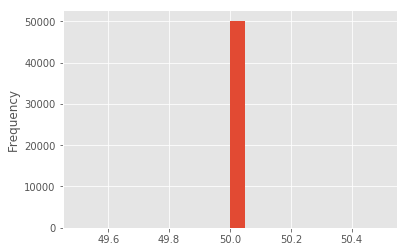

In [31]:
import matplotlib.pyplot as plt

for x in biopy_fastqs['Galaxy2-[adrenal_1']: print(x)
    
biopy_fastqs['Galaxy2-[adrenal_1']['df']['seq_whole'].str.len().plot(kind='hist', bins=20)
plt.show()

Ok, so now I've gotten numpy/pandas to load data with different-length reads.  The '`np.vstack()`' method doesn't work with these, but I can try to play around with the `np.pad()` method.

In [32]:
blah = biopy_fastqs['Galaxy2-[adrenal_1']['df']['seq_whole'].apply(np.vstack)

print('{}\n{}'.format(blah.shape, blah.T.shape))

(50121,)
(50121,)


Ok, so `np.vstack()` actually works on the '`seq_whole`' data, but not on quality scores or '`sequence`' itself.  Presumably this is because every entry in the '`seq_whole`' series is an array with the same shape as every other: they have 1 element, a string, although the strings themselves have different lengths.  By comparison, the '`sequence`' and '`quality`' series have arrays of different lengths.

So this would appear to be exactly where `np.pad()` could help.

...But I can't get it to pad all the elements to a common width.  Instead, it seems that the `pad` function is only used to add a set number of elements to every element over which it iterates.  Instead, I'll have to use a for loop to achieve what I want.

For some reason, whenever I call on pandas to describe the series of '`quality`' data for galaxy2_trimmed_paired, it causes the notebook to hang up.  Is this really beyond the memory capacity of the notebook, or my PC?

Calling the `describe()` method on up to 1000 rows works, although noticeably slower than for 100 rows.  10,000 rows doesn't seem like it will complete.

On the Mac, describing 100 rows takes about 161ms; 1,000 takes 12.4 seconds.  Obviously this dataset is difficult for either laptop to work with.  

---

<font color='red'>NOTE: Since the `parse_fastq()` function below has been modified to interpret trimmed reads, and since trimmed reads aren't compatible with the `plot_fastq()` function I'd written, I had to 'pad' the sequence and quality scores, and store those as separate dict and Pandas DataFrame values.<br /><br />

The way that I have padded them is dependent upon the assumption that these are only meant for the interpretation of per-base and per-sequence stats within notebooks like this one, and that they won't be carried forward for writing new fastq files for use with other software in the analysis pipeline, which won't accept exotic values.<br /><br />

I padded the quality scores with '`np.nan`', so that they wouldn't interfere with calculating stats about whole reads this also avoids any ambiguity about whether they came from the original quality scores assigned by the sequencer, or from the artificial process of padding them with this function for the purpose of internal analysis.  But since the sequence values of 'N' are valid outputs from the sequencer, to avoid any ambiguity about whether a base call comes from that source or was introduced by padding here, I've chosen to alter the `parse_fastq()` function to pad with the base letter of '`Z`'.<br /><br />

IF the output of any of these `dict`s will be carried forward using the padded values introduced here, either the `parse_fastq()` function should be modified again, perhaps to introduce '`0`' and '`N`' values for '`np.nan`' and '`Z`', respectively, or else a downstream function should convert these values prior to writing to a new fastq file.  Since I've chosen to keep the '`quality`' and '`sequence`' values separate in the `dict` from their respective '`quality_pad`' and '`sequence_pad`' values, however, I'm hoping this will prove unnecessary.</font>

In [33]:
from Bio import SeqIO
import pandas as pd
import os
import numpy as np
from collections import defaultdict

start_dir_PC = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq'
start_dir_Mac = '/Users/drew/Documents/Data/Python/Galaxy_rnaseq/'


def parse_fastq(start_dir, read_length=50):
    biopy_fastqs = {}
    phred_scale = 39   # Assuming Illumina data; change if diff qual score scale
    for file in os.listdir(start_dir):
        if file.split(sep='.')[-1] in ['fastqsanger', 'fastq']:
            name = file.split(sep='.')[0]
            file_path = os.path.join(start_dir, file)
            biopy_fastqs[name] = {}
            biopy_fastqs[name].update({'path': os.path.join(start_dir, file),
                                       'directory': start_dir,
                                       'seqs': []})
            for record in SeqIO.parse(file_path, "fastq"):
                quality = np.array(record.letter_annotations['phred_quality'])
                quality_pad = np.append(quality, [np.nan]*(read_length-len(quality)))
                sequence = np.array(list(str(record.seq)))
                sequence_pad = np.append(sequence, ['Z']*(read_length-len(sequence)))
                biopy_fastqs[name]['seqs'].append({'id': record.id, 
                                                   'sequence': sequence,
                                                   'sequence_pad': sequence_pad,
                                                   'seq_whole': str(record.seq),
                                                   'quality': quality,
                                                   'quality_pad': quality_pad,
                                                   'description' : record.description,
                                                   'name': record.name})
               
                
            biopy_fastqs[name]['df'] = pd.DataFrame.from_dict(biopy_fastqs[name]['seqs'])
            
            # Can use the np.vstack() method on quality scores and sequences
            # Once we've brought all axes up to the same, standard length
            biopy_fastqs[name]['per_base_qual'] = np.vstack(biopy_fastqs[name]['df']['quality_pad']).T
            biopy_fastqs[name]['per_base_seq'] = np.vstack(biopy_fastqs[name]['df']['sequence_pad']).T
            
            # Count base calls to dicts; one for raw counts, one for percentages:
            biopy_fastqs[name]['per_base_counts'] = []
            biopy_fastqs[name]['per_base_percents'] = []
            
            for i, row in enumerate(biopy_fastqs[name]['per_base_seq']):
                biopy_fastqs[name]['per_base_counts'].append(defaultdict())
                unique, counts = np.unique(row, return_counts=True)
                biopy_fastqs[name]['per_base_counts'][i] = dict(zip(unique, counts))
                
            for i, dictionary in enumerate(biopy_fastqs[name]['per_base_counts']):
                biopy_fastqs[name]['per_base_percents'].append(defaultdict())
                for k in dictionary.keys():
                    biopy_fastqs[name]['per_base_percents'][i][k] = dictionary[k] / sum(dictionary.values())
                        
            # Let's put the counts into a 'per_base_df':
            biopy_fastqs[name]['per_base_seq_df'] = pd.DataFrame.from_dict(
                biopy_fastqs[name]['per_base_counts'])#.fillna(value=0)
            biopy_fastqs[name]['per_base_percents_df'] = pd.DataFrame.from_dict(
                biopy_fastqs[name]['per_base_percents'])#.fillna(value=0)
            biopy_fastqs[name]['per_base_qual_df'] = pd.DataFrame(
                biopy_fastqs[name]['per_base_qual'])#.fillna(value=0)
            
            # add values for duplication level
            biopy_fastqs[name]['duplicates'] = biopy_fastqs[name]['df'].groupby(['seq_whole']).size()\
            .value_counts().sort_index()

            # add mean per_seq_qual
            biopy_fastqs[name]['mean_seq_qual'] = pd.cut(biopy_fastqs[name]['df']['quality'] \
                                                       .apply(np.mean), range(1, 41)).value_counts().sort_index()
            biopy_fastqs[name]['mean_seq_qual'].index = np.arange(2, phred_scale + 2)
            
            print('Added fastq file {0}'.format(name))

    print('')        
    print('Finished parsing directory.')
    return biopy_fastqs



In [34]:
biopy_fastqs = parse_fastq(start_dir_PC)
# biopy_fastqs = parse_fastq(start_dir_Mac)

Added fastq file Galaxy2-[adrenal_1
Added fastq file Galaxy3-[adrenal_2
Added fastq file Galaxy4-[brain_1
Added fastq file Galaxy5-[brain_2

Finished parsing directory.


Note: Up to this point in this notebook, I've only read in FastQ files and used BioPython to summarize their quality and modify their data **without writing those data out to a file**, as well as controlling Trimmomatic, which handles writing FastQ files itself.  When I try to write out FastQ files below (after removing reads whose mean quality scores were below a threshold), I found out that [BioPython's SeqIO module](http://biopython.org/wiki/SeqIO) is built around the assumption that any in-Python manipulations will be relatively short blocks of code, and writing out would be relatively simple because the record (i.e., sequencing read)'s data will have remained associated with all of its relevant parts via the SeqIO module.

Since I've adopted this whole approach of using a `parse_fastq()` function, I've created a complicated dict that loses that association (but gained the advantage that all of the relevant data associated with the sequence object have been broken out into more familiar Python types).  To write back to FastQ files, I can think of three main options, each with specific pros & cons:

* Add the SeqIO record as a specific object associated with each '`seq`' within each '`dict`' output by the `parse_fastq()` function.  This is the simplest to implement, but I'm not sure if it will greatly inflate the memory usage associated with the dict, and the respective time it would take to process the data in downstream operations.  I'm thinking it might be significant, since it'd be essentially duplicating much of the other info in the dict.

* Use any data manipulation from the `parse_fastq()`-output dict to just generate a list of sequence IDs, then refer back to the original input FastQ file to grab those IDs and write them out to a new file.  That's less simple than the first option to implement, but would probably be more memory-efficient.  A problem is that it would lose any potential modifications I make to any particular sequence's data within Python.  That hasn't really come up yet; I've trimmed  sequences with Trimmomatic, and padded them back out just to be able to more easily get summary data, but if I ever wanted to save any trim/pad info in the future, I'd have to find another workaround.

* Ignore the intricacies of using the SeqIO module to write out, and just make new files with a custom format along the lines indicated at the start of this notebook: FastQ files are inherently `['seq1_id', '+', 'seq1_qual']` repeated over however many lines needed.  I can certainly force that with the dicts I have (although some of the ID info was truncated, including the trailing '`/1`' / '`/2`' characters indicating which file is which read.  **Alternatively, as a modification of this approach, I could perhaps use the SeqIO module by setting the dict-filtered data for each read to create new SeqIO '`record`' objects, then write these out to files, in case any intricacies of formatting that I haven't noticed are important.**

I'll try the last approach first; even though it's the most involved, it is the most flexible.

In [35]:
import Bio.SeqIO
import datetime
import errno
import os


def make_subdirs(fastq_dict, out_dir_suffix=None):
    # A function to create new subdirs, if needed, 
    # using datetime if no particular name is specified:
    name_dir = {}
    
    if out_dir_suffix != None:
        suffix = str(out_dir_suffix)
    elif out_dir_suffix == None:
        suffix = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    
    # Get all of the directories 
    # associated with files in the dict
    dirs = set()
    for fastq_name in fastq_dict.keys():
        dir_temp = fastq_dict[fastq_name]['directory']
        dirs.add(dir_temp)
        name_dir[fastq_name] = dir_temp
        
    # Make name for new subdirs
    for directory in dirs:
        new_dir = os.path.join(directory, suffix)
        # Associate FastQ files with new subdir name
        for fastq_name in name_dir:
            if name_dir[fastq_name] == directory:
                name_dir[fastq_name] = new_dir
        # Write the directories
        try:
            os.makedirs(new_dir)
            print('Wrote {}'.format(new_dir))
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
    
    return name_dir


def write_fastq(fastq_dict, out_dir=None, out_dir_suffix=None):
    # Initialize a dict to store assoc between
    # FastQ files and the dirs they go to
    name_dir = {}

    # If user-specified outdir given
    # (i.e., one dir to put all files in):
    if out_dir != None:
        for fastq_name in fastq_dict:
            name_dir[fastq_name] = out_dir
            
        # If the dir doesn't already exist, make it
        if os.path.isdir(out_dir) == False:
            try:
                os.makedirs(out_dir)
            except OSError as e:
                if e.errno != errno.EEXIST:
                    raise
            
    # If out_dir_suffix given (i.e., fastq_dict contains
    # files in various dirs, and user wants a specific name
    # associated with each subdir):
    elif out_dir == None:
        name_dir = make_subdirs(fastq_dict,
                                out_dir_suffix=out_dir_suffix)

    # Or: I'm not using args correctly
    else:
        print('Interpretation error in arg "out_dir" or "out_dir_suffix".')
    
    # Now, iterate through the fastq files in the dict
    # write them to new SeqRecord objects, and write to files
    for fastq_name in sorted(fastq_dict):
        records = []
        df = fastq_dict[fastq_name]['df']
        for index, row in df.iterrows():
            record = SeqIO.SeqRecord(seq=row['seq_whole'],
                                     id=row['description'],
                                     letter_annotations={'phred_quality': row['quality']},
                                     description='')
            records.append(record)

        filename = os.path.join(name_dir[fastq_name],
                                fastq_name+'.fastq')
        with open(filename, 'w+') as f:
            SeqIO.write(records, handle=f, format='fastq')
        
        print('')    
        print('{0} written to {1}'.format(fastq_name, filename))
        
    print('')
    print('Finished writing dict to fastq.')

In [36]:
dummy_dir_PC = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\dummy'

# write_fastq(biopy_fastqs, out_dir=dummy_dir_PC)

# write_fastq(biopy_fastqs, out_dir_suffix='blah')

# write_fastq(biopy_fastqs)

Ok, after a LOT of fiddling, I got that to work the way I wanted.  At first I had tried referring to the dict entries for each seq to populate the output files, but indexing nested dicts is tricky, and finally I found it easier to grab the entries from the Pandas DataFrame instead.

I noticed that in the output fastq files, the formatting looked pretty OK, except that the first entry was like this:

    @ERR030881.107 <unknown description>
    CGGATTTCAGCTACTGCAAGCTCAGTACCACAGCCTCAAGCTCGAATGTG
    +
    HH;HHHHHGHHHHHHHHHHGHDHEHHHHHEHHHHBHHFHHHHHHHHHD0F
    
Whereas in the original `Galaxy3-[adrenal_2.fastq].fastqsanger` file it was:

    @ERR030881.107 HWI-BRUNOP16X_0001:2:1:13663:1096#0/2
    CGGATTTCAGCTACTGCAAGCTCAGTACCACAGCCTCAAGCTCGAATGTG
    +
    HH;HHHHHGHHHHHHHHHHGHDHEHHHHHEHHHHBHHFHHHHHHHHHD0F
    
So it seems that the relevant parameter in which to save that additional info is the '`description`' attribute for the SeqIO.SeqRecord object.  Therefore I should be able to write that into the original `parse_fastq()` function and keep that info for each read (the info about the Illumina machine on which it was read is nonessential, but the info that keeps it paired with its opposite in another file is pretty relevant).  I'll try making that change to the last instance of the `parse_fastq()` function above.

...That **pretty much** works, except that apparently BioPython's behavior with FastQ files is to parse the first line for each read with the stuff before the space being the 'record.id' feature, and the ENTIRE line as the 'record.description' feature.  There's an additional feature it can grab from this row, called '`record.name`', but that apparently ends up as the same as '`record.id`'.  So if I ask the `fastq_write()` function to write '`name`' AND '`description`', it'd end up just repeating the id in the same line.  Instead, I'll just set the function to write the `description` as the `name`.

That worked, but the danged SeqIO still tags '`<unknown description>`' onto the end:

    @ERR030881.107 HWI-BRUNOP16X_0001:2:1:13663:1096#0/1 <unknown description>
    ATCTTTTGTGGCTACAGTAAGTTCAATCTGAAGTCAAAACCAACCAATTT
    +
    5.544,444344555CC?CAEF@EEFFFFFFFFFFFFFFFFFEFFFEFFF
    
I'll modify the '`write_fastq()`' function again to explicitly declare that the record.description should be None, or an empty string or something.  Ok, `None` didn't work, but an empty string did.  It didn't add any trailing whitespace to the line, and since a fastq file has limited formatting nuance, I would expect subsequent programs to treat it as legit.

Ok, I'm sure this could be improved upon, but that's not bad.  I've finally hit the goal of automating the gathering and parsing of all fastq files in a dir, and plotting their summary characteristics in a manner that scales with the number of files.  Actually, I'm noticing a flaw with the duplication level of the last file; the 'trimmed_unpaired' (last plot) doesn't have nearly as many reads, but the plotter still stretches the y axis to occupy the full space, even though I tried to specify that it should share the same y axis throughout the row.  Eh, anyways, for now I'll skip running that down, and get down to optimizing trim parameters (I should probably add a function that summarizes read counts after trimming, and maybe build this into the trimmomatic caller), and run some small-scale alignments before submitting a big job to use the full dataset.

---

Actually, I just realized that I never applied a mean sequence quality cutoff prior to using Trimmomatic.  I'll write a short function now to do that for all fastq files in a dict of parsed fastq files, so that you can get rid of any particularly low-quality reads, either before or after trimming based on per-base call quality scores.

Note: In order to get proper formatting for the output info about how many reads were dropped, [I had to](https://stackoverflow.com/questions/28343745/print-sign-with-string-formatting) make [extensive use](https://stackoverflow.com/questions/8234445/python-format-output-string-right-alignment) of the ['`print(''.format)`'](https://stackoverflow.com/questions/29613676/python-typeerror-non-empty-format-string-passed-to-object-format) functionality [in Python](https://docs.python.org/3/tutorial/inputoutput.html).

Also, in the course of making the `write_fastq()` function, I ended up deleting the trimmed fastq files in the source dir, so I'll regenerate those now using the `trimmomatic_paired()` function.

**ACTUALLY**, I just noticed from the plots above that the wonky ACGT percentages for the first 10 bases of each file are far too similar.  Check out, specifically, how 'A' is elevated for positions ~2-5 and depressed for positions ~6-8 for all libraries, even after trimming.  This suggests strongly some adapter sequences that didn't get trimmed.  So I'll try adding parameters to the trimmomatic function and the corresponding call to look for these.  The [Trimmomatic docs](http://www.usadellab.org/cms/?page=trimmomatic) state that 'TruSeq3' is the appropriate choice of FASTA input for all HiSeq and MiSeq runs, and the [docs for the source reads](https://www.ncbi.nlm.nih.gov/biosample/SAMEA962342) states they were HiSeq.

But that doesn't find the adapters fasta file.  I'll have to add more code to provide for the path to those files.  These did indeed come with the install zip; on the PC they're at:

    C:\Users\DMacKellar\Documents\Python\BioPython\Trimmomatic-0.36\adapters
    
...I tried adding that full path into the commands, but the problem is that the Trimmomatic tool interprets colons as separating important inputs within the ILLUMINACLIP command, so it ends up taking '`C:`' as the fasta file with the adapter sequences.  As a workaround, I'll have the program execute within the dir containing the adapters sequences.

In [37]:
import sys
import os
import subprocess


def trimmomatic_paired(fastq_dict, mac_pc='mac', subdir=True, 
                       subdir_suffix=None, verbose=False, **kwargs):
    
    # Set the path for trimmomatic based on which laptop I'm using
    rand_entry = list(fastq_dict.keys())[0]
    if mac_pc == 'mac':
        trim_path = '/Users/drew/Documents/Data/Bio/\
Trimmomatic-0.36/trimmomatic-0.36.jar'
        commands = []
        sep = ';'
    elif mac_pc == 'pc':
        trim_path = r'C:\Users\DMacKellar\Documents\Python\\
BioPython\Trimmomatic-0.36\trimmomatic-0.36.jar'
        commands = []
        sep = ' & '
    else:
        print('Please specify "mac_pc" arg as "mac" or "pc"')
    
    adapter_path = os.path.join(os.path.dirname(trim_path), 'adapters')
    os.chdir(adapter_path)
    
    # Confirm that the trimmomatic jar file exists
    try:
        os.path.isfile(trim_path)
    except:
        print('trimmomatic.jar file not found at expected location')
        sys.exit(1)   # abort the function
    
    # Confirm that the input dict 
    # contains an even number of fastq files
    try:
        len(fastq_dict) % 2 != 0
    except:
        print('Input has odd number of fastq files; \
\nPlease enter paired end data.')
        sys.exit(1)   # abort the function
        
    use_kwargs = {}
    
    # Specify valid kwarg keys and default values
    default_kwargs = {
        'phred': '-phred33',
        'ILLUMINACLIP': '',
        'LEADING': 'LEADING:25',
        'TRAILING': 'TRAILING:25',
        'SLIDINGWINDOW': '',
        'MINLEN': 'MINLEN:30'
    }
    
    # For any input kwargs, pass them to the use_kwargs dict
    for key, value in kwargs.items():
        if key in default_kwargs:
            use_kwargs[key] = value
            # If adapter trimming requested,
            # Confirm location of adapter fasta file
            if (key=='ILLUMINACLIP') & (value != ''):
                illclip_split = value.split(sep=':')
                adapter_file = os.path.join(adapter_path,
                                            illclip_split[1])
                try:
                    os.path.isfile(adapter_file)
                except OSError as err:
                    print('Adapter file {0} not found.'.format(adapter_file))
                    sys.exit(1)   # abort the function

        else:
            print('kwarg key, value pair: {0}: {1} not understood;\
please specify key in a case-sensitive manner.\
Default kwargs are: {3}'.format(key,
                                value,
                                **default_kwargs))
    
    # For any kwargs not fed to input, use defaults
    for key, value in default_kwargs.items():
        if key not in use_kwargs:
            use_kwargs[key] = value
            
    print('kwarg key, value pairs used: ', use_kwargs)
    
    name_dir = {}
    if subdir == True:
        if subdir_suffix != None:
            # Use user-defined subdir name
            name_dir = make_subdirs(fastq_dict,
                                out_dir_suffix=str(subdir_suffix))
        elif subdir_suffix == None:
            # Make new subdir to put files in
            name_dir = make_subdirs(fastq_dict,
                                    out_dir_suffix='trim_L{0}_T{1}'
                                    .format(use_kwargs['LEADING'].split(sep=':')[1],
                                            use_kwargs['TRAILING'].split(sep=':')[1]))
    elif subdir == False:
        for fastq_name in fastq_dict:
            name_dir[fastq_name] = fastq_dict[fastq_name]['directory']
        
    # Format and output the relevant commands
    fastq_paths = [fastq_dict[x]['path'] for x in sorted(fastq_dict)]
    output_paths = [os.path.join(name_dir[x], x) for x in sorted(fastq_dict)]
    forward_paths = fastq_paths[0::2]
    reverse_paths = fastq_paths[1::2]
    out_f_paths = output_paths[0::2]
    out_r_paths = output_paths[1::2]
    
    for f_p, r_p, f_outp, r_outp in zip(forward_paths, reverse_paths,
                                        out_f_paths, out_r_paths):
        trim_commands = ['java -jar', trim_path, 'PE', use_kwargs['phred'],
                        use_kwargs['ILLUMINACLIP'], use_kwargs['LEADING'], 
                        use_kwargs['TRAILING'], use_kwargs['SLIDINGWINDOW'], 
                        use_kwargs['MINLEN']]

        to_insert = [f_p, r_p, '%s_trimmed_paired.fastq' % f_outp,
                     '%s_trimmed_unpaired.fastq' % f_outp,
                     '%s_trimmed_paired.fastq' % r_outp,
                     '%s_trimmed_unpaired.fastq' % r_outp]
        for i, thing in enumerate(to_insert):
            trim_commands.insert(4+i, thing)

        trim_commands = ' '.join(trim_commands)
        commands.append(trim_commands)
        
    commands = sep.join(commands)
    stdout = subprocess.run(commands, stdout=subprocess.PIPE, 
                   stderr=subprocess.STDOUT, shell=True,
                   check=True)
    if verbose==True:
        for x in stdout.stdout.splitlines():
            print(x.decode('utf-8'))
#     return commands
    return stdout



In [38]:
trim_kwargs = {'ILLUMINACLIP': 'ILLUMINACLIP:TruSeq3-PE-2.fa:2:30:10'}

stdout = trimmomatic_paired(biopy_fastqs,
                            mac_pc='pc',
                            verbose=True,
                            subdir=True,
                            **trim_kwargs)

kwarg key, value pairs used:  {'ILLUMINACLIP': 'ILLUMINACLIP:TruSeq3-PE-2.fa:2:30:10', 'phred': '-phred33', 'LEADING': 'LEADING:25', 'TRAILING': 'TRAILING:25', 'SLIDINGWINDOW': '', 'MINLEN': 'MINLEN:30'}
TrimmomaticPE: Started with arguments:
 -phred33 C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\Galaxy2-[adrenal_1.fastq].fastqsanger C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\Galaxy3-[adrenal_2.fastq].fastqsanger C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25\Galaxy2-[adrenal_1_trimmed_paired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25\Galaxy2-[adrenal_1_trimmed_unpaired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25\Galaxy3-[adrenal_2_trimmed_paired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25\Galaxy3-[adrenal_2_trimmed_unpaired.fastq ILLUMINACLIP:TruSeq3-PE-2.fa:2:30:10 LEADING:25 TRAILING:25 MINLEN:30
Multiple cores foun

In [39]:
trim_dir = r'C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25'
trim1_dict = parse_fastq(trim_dir)

Added fastq file Galaxy2-[adrenal_1_trimmed_paired
Added fastq file Galaxy2-[adrenal_1_trimmed_unpaired
Added fastq file Galaxy3-[adrenal_2_trimmed_paired
Added fastq file Galaxy3-[adrenal_2_trimmed_unpaired
Added fastq file Galaxy4-[brain_1_trimmed_paired
Added fastq file Galaxy4-[brain_1_trimmed_unpaired
Added fastq file Galaxy5-[brain_2_trimmed_paired
Added fastq file Galaxy5-[brain_2_trimmed_unpaired

Finished parsing directory.


Hmm... Now Trimmomatic is returning flawed sequences.  I've re-run the trim module four times, and whenever I try to parse the output, BioPython returns an error; thrice it was about differing lengths for the respective sequence and quality scores for some read.  The read in question varies every time, and checking them in the fastq file indeed reveals that BioPython is correct.  One time the parser returned 'whitespace is not allowed in the sequence'.  I really don't know why I'm seeing this; I didn't have this problem the first time I wrote the '`trimmomatic_paired`' function.

I'll try running manually from the command line to see whether there's some wrinkle being introduced via running from the notebook:

    # (on PC):
    cd C:\Users\DMacKellar\Documents\Python\BioPython\Trimmomatic-0.36\adapters
    java -jar C:\Users\DMacKellar\Documents\Python\BioPython\Trimmomatic-0.36\trimmomatic-0.36.jar PE -phred33 C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\Galaxy2-[adrenal_1.fastq].fastqsanger C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\Galaxy3-[adrenal_2.fastq].fastqsanger C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25\output_forward_paired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25\output_forward_unpaired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25\output_reverse_paired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\trim_L25_T25\output_reverse_unpaired.fastq ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 LEADING:25 TRAILING:25 MINLEN:30
    
Ok, yes: that does execute just fine when input manually to the command line.  **BUT** if I use the function to prepare the commands as a string, then copy and paste *that* into the command line, the output also fails to parse.  So there's something specific about the difference in the code prepared by the function, not the effect of just running it from within the notebook.

The commands aren't formatted EXACTLY the same way, however; the manual one I did above has slightly different names given to the output fastq files, and each path contains double-backslashes.  I'll try re-formatting the input command for a manual submission to more closely match the function's output, to try to narrow down possible sources of this difference:

    # (on PC):
    cd C:\Users\DMacKellar\Documents\Python\BioPython\Trimmomatic-0.36\adapters
    java -jar C:\Users\DMacKellar\Documents\Python\BioPython\Trimmomatic-0.36\trimmomatic-0.36.jar PE -phred33  C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\Galaxy2-[adrenal_1.fastq].fastqsanger C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\Galaxy3-[adrenal_2.fastq].fastqsanger C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\trim_L25_T25\\Galaxy2-[adrenal_1_trimmed_paired.fastq C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\trim_L25_T25\\Galaxy2-[adrenal_1_trimmed_unpaired.fastq C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\trim_L25_T25\\Galaxy2-[adrenal_1_trimmed_paired.fastq C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\trim_L25_T25\\Galaxy2-[adrenal_1_trimmed_unpaired.fastq ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 LEADING:25 TRAILING:25 MINLEN:30

Aha, now THAT generates an error when parsing the output.  There's something about these filename paths that's somehow causing Trimmomatic to behave erratically.

    # (on PC):
    cd C:\Users\DMacKellar\Documents\Python\BioPython\Trimmomatic-0.36\adapters
    java -jar C:/Users/DMacKellar/Documents/Python/BioPython/Trimmomatic-0.36/trimmomatic-0.36.jar PE -phred33  C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/Galaxy2-[adrenal_1.fastq].fastqsanger C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/Galaxy3-[adrenal_2.fastq].fastqsanger C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/trim_L25_T25/Galaxy2-[adrenal_1_trimmed_paired.fastq C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/trim_L25_T25/Galaxy2-[adrenal_1_trimmed_unpaired.fastq C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/trim_L25_T25/Galaxy2-[adrenal_1_trimmed_paired.fastq C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/trim_L25_T25/Galaxy2-[adrenal_1_trimmed_unpaired.fastq ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 LEADING:25 TRAILING:25 MINLEN:30
    
Well, getting rid of all the backslashes doesn't help; it's still an error upon parsing.  I'll try just changing the filenames.

    # (on PC):
    cd C:\Users\DMacKellar\Documents\Python\BioPython\Trimmomatic-0.36\adapters
    java -jar C:/Users/DMacKellar/Documents/Python/BioPython/Trimmomatic-0.36/trimmomatic-0.36.jar PE -phred33  C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/Galaxy2-[adrenal_1.fastq].fastqsanger C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/Galaxy3-[adrenal_2.fastq].fastqsanger C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/trim_L25_T25/a.fastq C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/trim_L25_T25/b.fastq C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/trim_L25_T25/c.fastq C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/trim_L25_T25/d.fastq ILLUMINACLIP:TruSeq3-PE.fa:2:30:10 LEADING:25 TRAILING:25 MINLEN:30
    
That helps.  But now I finally see the difference: it wasn't the path or filenames of the outputs above that mattered so much, it was the fact (that I didn't notice up until now) that running the function's output generates only two output files, both labeled 'Galaxy2...', instead of two each for `Galaxy2` and `Galaxy3`.  It seems that, when I modified the function above to generate output paths for the full dict, I didn't consider that it might have a different length than the input path lists.

Here's the code from the function (lines 95-117) that was causing the issue:

    # Format and output the relevant commands
    fastq_paths = [fastq_dict[x]['path'] for x in sorted(fastq_dict)]
    output_paths = [os.path.join(name_dir[x], x) for x in sorted(fastq_dict)]
    forward_paths = fastq_paths[0::2]
    reverse_paths = fastq_paths[1::2]
    
    for f_p, r_p, out in zip(forward_paths, reverse_paths, output_paths):
        trim_commands = ['java -jar', trim_path, 'PE', use_kwargs['phred'],
                        use_kwargs['ILLUMINACLIP'], use_kwargs['LEADING'], 
                        use_kwargs['TRAILING'], use_kwargs['SLIDINGWINDOW'], 
                        use_kwargs['MINLEN']]

        to_insert = [f_p, r_p, '%s_trimmed_paired.fastq' % out,
                     '%s_trimmed_unpaired.fastq' % out,
                     '%s_trimmed_paired.fastq' % out,
                     '%s_trimmed_unpaired.fastq' % out]
        for i, thing in enumerate(to_insert):
            trim_commands.insert(4+i, thing)

        trim_commands = ' '.join(trim_commands)
        commands.append(trim_commands)
        
    commands = sep.join(commands)
    
When I add a print statement to get the length of each list being fed into the 'for f_p...' line, I get:

    output_paths: 4 forward_paths:  2 reverse_paths:  2
    
So the function was writing 'Galaxy2...\_trimmed\_unpaired.fastq' out, then overwriting it with the output from trimming Galaxy3, and this was somehow screwing up the output in a way that made individual reads inconsistent.  I'll fix that now, by subjecting the '`output_paths`' variable to the same slicing that the '`fastq_paths`' list gets.

Ok, that appears to have done the trick.  Man, it's super annoying how long it can take to track down such a simple error when coding.  Still, at least I was able to take the appropriate steps to keep things moving forward.

Anyways, the next step was going to be to filter the trimmed reads for average quality, but I'll skip that for now.  [This short post](http://www.drive5.com/usearch/manual/avgq.html) suggests that it's not very applicable in the preprocessing of sequence data.


---

**BUT:** The adapters are still there.  Using the ILLUMINACLIP settings didn't change the per-base skew that's apparent when looking at the plots.  I'm betting the Trimmomatic-supplied fasta files are out-of-date, or otherwise weren't the right ones for this dataset.  After looking around online, I found a [more comprehensive](https://github.com/csf-ngs/fastqc/blob/master/Contaminants/contaminant_list.txt) collection of contaminant sequences, and will try using that as an input file for trimmomatic.  Unfortunately, the file's format isn't fasta, so I'll have to re-format it first.

In [40]:
import re

path1 = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\BioPython\idot_github_contaminant_list.txt'
path2 = r'C:\Users\DMacKellar\Dropbox\Coding\\
Python\BioPython\idot_github_contaminant_list.fasta'
path3 = r'C:\Users\DMacKellar\Documents\Python\\
BioPython\Trimmomatic-0.36\adapters\idot_github_contaminant_list.fasta'

with open(path1, 'r') as f:
    lines = f.readlines()
    pattern = re.compile(r'(\t)+')
    illumina = []
    
    for line in lines[17:160]:
        substitutes = {' ': '_'}#, pattern.match(line): '\n'}
        for key, value in substitutes.items():
            if line == '\n':
                continue
            newline = '>'+line.replace(key, value)
            newline = re.sub(pattern, '\n', newline)
        illumina.append(newline)
        
with open(path3, 'w') as f2:
    for line in illumina:
        f2.write(line)

In [41]:
illumina[:3]

['>Illumina_Single_End_Adapter_1\nACACTCTTTCCCTACACGACGCTGTTCCATCT\n',
 '>Illumina_Single_End_Adapter_2\nCAAGCAGAAGACGGCATACGAGCTCTTCCGATCT\n',
 '>Illumina_Single_End_PCR_Primer_1\nAATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCT\n']

In [42]:
trim_kwargs = {'ILLUMINACLIP': 
               'ILLUMINACLIP:idot_github_contaminant_list.fasta:2:30:7'}

stdout = trimmomatic_paired(biopy_fastqs,
                            mac_pc='pc',
                            verbose=True,
                            subdir=True,
                            subdir_suffix='contaminant_trim',
                            **trim_kwargs)

kwarg key, value pairs used:  {'ILLUMINACLIP': 'ILLUMINACLIP:idot_github_contaminant_list.fasta:2:30:7', 'phred': '-phred33', 'LEADING': 'LEADING:25', 'TRAILING': 'TRAILING:25', 'SLIDINGWINDOW': '', 'MINLEN': 'MINLEN:30'}
TrimmomaticPE: Started with arguments:
 -phred33 C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\Galaxy2-[adrenal_1.fastq].fastqsanger C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\Galaxy3-[adrenal_2.fastq].fastqsanger C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\contaminant_trim\Galaxy2-[adrenal_1_trimmed_paired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\contaminant_trim\Galaxy2-[adrenal_1_trimmed_unpaired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\contaminant_trim\Galaxy3-[adrenal_2_trimmed_paired.fastq C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\contaminant_trim\Galaxy3-[adrenal_2_trimmed_unpaired.fastq ILLUMINACLIP:idot_github_contaminant_list.fasta:2:30:7 

In [43]:
trim2_dir = r'C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/contaminant_trim/'
trim2_dict = parse_fastq(trim2_dir)

Added fastq file Galaxy2-[adrenal_1_trimmed_paired
Added fastq file Galaxy2-[adrenal_1_trimmed_unpaired
Added fastq file Galaxy3-[adrenal_2_trimmed_paired
Added fastq file Galaxy3-[adrenal_2_trimmed_unpaired
Added fastq file Galaxy4-[brain_1_trimmed_paired
Added fastq file Galaxy4-[brain_1_trimmed_unpaired
Added fastq file Galaxy5-[brain_2_trimmed_paired
Added fastq file Galaxy5-[brain_2_trimmed_unpaired

Finished parsing directory.


In [44]:
%%time

plot_fastq(trim2_dict, per_row=4)

TypeError: plot_fastq() got an unexpected keyword argument 'per_row'

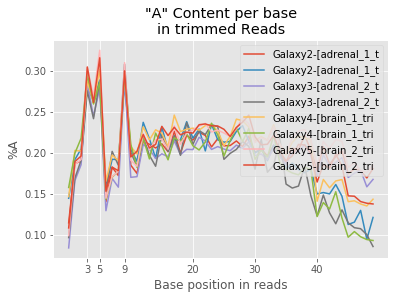

In [45]:
import matplotlib.pyplot as plt

allyourbase = pd.DataFrame()

for x in trim2_dict:
#     trim2_dict[x]['per_base_percents_df'].A.plot(kind='line')
    plt.plot(trim2_dict[x]['per_base_percents_df'].A, label=x[:20])
    allyourbase = allyourbase.append(trim2_dict[x]['per_base_percents_df'].A)
    
plt.title('"A" Content per base\nin trimmed Reads')
plt.xlabel('Base position in reads')
plt.ylabel('%A')
ticks = allyourbase.sum().T.nlargest(3).index.tolist()
ticks.extend(range(20, 50, 10))
plt.xticks(ticks)
plt.grid(True, axis='x')
plt.legend()
plt.show()

Ok, that didn't get rid of the biased first few bases either.  As far as I know, there's no compelling biological reason that the reads should all have A content that peaks at bases 3, 5, and 9 in every transcript.  This is almost certainly a sequencing artifact.

Let's try a more direct approach: can I just look at a dozen or so sequences and see the commonalities in those first few bases?

In [46]:
biopy_fastqs['Galaxy2-[adrenal_1']['df']['sequence'][:10]

0    [A, T, C, T, T, T, T, G, T, G, G, C, T, A, C, ...
1    [T, C, C, A, T, A, C, A, T, A, G, G, C, C, T, ...
2    [G, T, A, T, A, A, C, G, C, T, A, G, A, C, A, ...
3    [A, A, C, G, G, A, T, C, C, A, T, T, G, T, T, ...
4    [G, C, T, A, A, T, C, C, G, A, C, T, T, C, T, ...
5    [T, G, G, A, C, A, G, T, T, G, C, T, C, C, T, ...
6    [A, T, T, A, G, G, A, A, A, C, A, T, G, G, A, ...
7    [C, A, A, T, A, G, C, C, A, G, A, T, G, G, T, ...
8    [G, T, G, C, C, A, A, A, T, T, G, T, C, A, C, ...
9    [C, C, C, G, G, C, C, T, A, A, C, T, T, T, C, ...
Name: sequence, dtype: object

## Going Back to the Source

Yeah, I still don't see it.  I don't know what's causing that base content skew.  Maybe they're nothing to worry about, but it's a very noticable regularity.

Maybe I should check the raw data from the experiment, rather than this curated source?  I doubt that it's so different, but it's worth noting that the Illumina BodyMap 2.0 project generated *far*, far more data than this limited dataset.  I can't be certain that other aspects of the data weren't altered.

As noted at the top of this notebook, the full set of reads are available on NCBI's SRA.  To interact with that repository, however, they require you to download their special software; the reads aren't available via any kind of structured URL query.

### SRA Toolkit Setup

Binaries are available for Linux, Mac OS X, and Windows.  Instructions are [here](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std).  I put the unzipped output on the Mac at:

    /Users/drew/Documents/Data/Bio/sratoolkit
    
On PC at:

    C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\sratoolkit\sratoolkit.2.8.2-1-win64\bin
    
Once those are installed, use the [prefetch tool](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=prefetch) to download the sequences with the specific accession number.  Or, [perhaps](https://www.ncbi.nlm.nih.gov/books/NBK158899/#SRA_download.downloading_sra_data_using) that's unnecessary.

Then, you have to use their [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) program to get the FastQ (or FASTA) file from the raw image data that includes the flow cell the way the sequencer saw it.

    # (on Mac):
    cd /Users/drew/Documents/Data/Python/Galaxy_rnaseq
    curl ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/ERP000546
    /Users/drew/Documents/Data/Bio/sratoolkit/bin/fastq-dump -X 5 -Z ERP000546
    
Hmm... those both return errors.  Using the '`fastq-dump`' command gives:

    fastq-dump.2.8.2 err: item not found while constructing within virtual database module - the path 'ERP000546' cannot be opened as database or table
    
Using `curl` gives:

    curl: (78) RETR response: 550
    
Which [apparently](https://curl.haxx.se/mail/lib-2009-02/0155.html) means (~99% of the time) 'file not found'.  So I'm having trouble figuring out how to download SRA data.

On PC, the [trial code](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std#header-global):

    fastq-dump.exe -X 5 -Z SRR390728
    
does work, outputting the first 5 reads from that dataset.  I didn't have to run the config for the tool.  I'll try

    cd C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\SRA_raw
    C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\sratoolkit\sratoolkit.2.8.2-1-win64\bin\fastq-dump.exe -X 10000 -A C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\accession.txt
    
Nope, that gives:

    2017-11-10T03:01:31 fastq-dump.2.8.2 err: item not found while constructing within virtual database module - the path '/C/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/accession.txt' cannot be opened as database or table
    
Apparently just feeding a text file of accessions won't work with the '`-A`' flag.

Maybe this is a job for `prefetch`?

    cd C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\SRA_raw
    C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\sratoolkit\sratoolkit.2.8.2-1-win64\bin\prefetch.exe --list C:\Users\DMacKellar\Documents\Python\BioPython\Galaxy_rnaseq\accession.txt
    
Nope; that wants a properly formatted 'kart file', and it sounds like the only way to get that is to [go through the website](https://www.ncbi.nlm.nih.gov/books/NBK36439/#Download.download_using_prefetch_command).  It sounds like they expect you to just enter multiple calls to `prefetch` or `fastq-dump` with one accession each.  I guess that makes sense when many modern fastq raw read files are >1GB in size.

I think I'll try to do this via the `subprocess` module:

In [47]:
import sys
import os
import platform
import subprocess

# def run_subprocess(accession, **kwargs):
#     commands = ' '.join([dump, **kwargs])
#     stdout = subprocess.run(command, stdout=subprocess.PIPE, 
#                stderr=subprocess.STDOUT, shell=True,
#                check=True)
#     if verbose==True:
#         for x in stdout.stdout.splitlines():
#             print(x.decode('utf-8'))

#     return stdout

def sra_download(accessions_list, verbose=False, *kwargs):
    tools_path_pc = r'C:\Users\DMacKellar\Documents\Python\BioPython\\
    Galaxy_rnaseq\sratoolkit\sratoolkit.2.8.2-1-win64\bin'
    tools_path_mac = '/Users/drew/Documents/Data/Bio/sratoolkit/bin'
    if platform.system() == 'Windows':
        tools_path = tools_path_pc
    elif platform.system() == 'Mac':
        tools_path = tools_path_mac
    else:
        print('Couldn\'t determine the Operating System,\
        and path to SRA tools.')
        
    if os.path.isfile(accessions_list):
        # if input list is actually a file with accessions
        with open(accessions_list, 'r') as f:
            accessions_list = [line.rstrip() for line in f]
    # otherwise, it should be a Python variable
    else:
        pass
        
    # Use fastq-dump:
    dump = os.path.join(tools_path, 'fastq-dump')
        
    for acc in accessions_list:
        commands = ' '.join([dump, kwargs])
        stdout = subprocess.run(command, stdout=subprocess.PIPE, 
                   stderr=subprocess.STDOUT, shell=True,
                   check=True)
        if verbose==True:
            for x in stdout.stdout.splitlines():
                print(x.decode('utf-8'))
    #     return commands
        return stdout
    


# def trimmomatic_paired(fastq_dict, mac_pc='mac', subdir=True, 
#                        subdir_suffix=None, verbose=False, **kwargs):
    
#     # Set the path for trimmomatic based on which laptop I'm using
#     rand_entry = list(fastq_dict.keys())[0]
#     if mac_pc == 'mac':
#         trim_path = '/Users/drew/Documents/Data/Bio/\
# Trimmomatic-0.36/trimmomatic-0.36.jar'
#         commands = []
#         sep = ';'
#     elif mac_pc == 'pc':
#         trim_path = r'C:\Users\DMacKellar\Documents\Python\\
# BioPython\Trimmomatic-0.36\trimmomatic-0.36.jar'
#         commands = []
#         sep = ' & '
#     else:
#         print('Please specify "mac_pc" arg as "mac" or "pc"')
    
#     adapter_path = os.path.join(os.path.dirname(trim_path), 'adapters')
#     os.chdir(adapter_path)
    
#     # Confirm that the trimmomatic jar file exists
#     try:
#         os.path.isfile(trim_path)
#     except:
#         print('trimmomatic.jar file not found at expected location')
#         sys.exit(1)   # abort the function
    
#     # Confirm that the input dict 
#     # contains an even number of fastq files
#     try:
#         len(fastq_dict) % 2 != 0
#     except:
#         print('Input has odd number of fastq files; \
# \nPlease enter paired end data.')
#         sys.exit(1)   # abort the function
        
#     use_kwargs = {}
    
#     # Specify valid kwarg keys and default values
#     default_kwargs = {
#         'phred': '-phred33',
#         'ILLUMINACLIP': '',
#         'LEADING': 'LEADING:25',
#         'TRAILING': 'TRAILING:25',
#         'SLIDINGWINDOW': '',
#         'MINLEN': 'MINLEN:30'
#     }
    
#     # For any input kwargs, pass them to the use_kwargs dict
#     for key, value in kwargs.items():
#         if key in default_kwargs:
#             use_kwargs[key] = value
#             # If adapter trimming requested,
#             # Confirm location of adapter fasta file
#             if (key=='ILLUMINACLIP') & (value != ''):
#                 illclip_split = value.split(sep=':')
#                 adapter_file = os.path.join(adapter_path,
#                                             illclip_split[1])
#                 try:
#                     os.path.isfile(adapter_file)
#                 except OSError as err:
#                     print('Adapter file {0} not found.'.format(adapter_file))
#                     sys.exit(1)   # abort the function

#         else:
#             print('kwarg key, value pair: {0}: {1} not understood;\
# please specify key in a case-sensitive manner.\
# Default kwargs are: {3}'.format(key,
#                                 value,
#                                 **default_kwargs))
    
#     # For any kwargs not fed to input, use defaults
#     for key, value in default_kwargs.items():
#         if key not in use_kwargs:
#             use_kwargs[key] = value
            
#     print('kwarg key, value pairs used: ', use_kwargs)
    
#     name_dir = {}
#     if subdir == True:
#         if subdir_suffix != None:
#             # Use user-defined subdir name
#             name_dir = make_subdirs(fastq_dict,
#                                 out_dir_suffix=str(subdir_suffix))
#         elif subdir_suffix == None:
#             # Make new subdir to put files in
#             name_dir = make_subdirs(fastq_dict,
#                                     out_dir_suffix='trim_L{0}_T{1}'
#                                     .format(use_kwargs['LEADING'].split(sep=':')[1],
#                                             use_kwargs['TRAILING'].split(sep=':')[1]))
#     elif subdir == False:
#         for fastq_name in fastq_dict:
#             name_dir[fastq_name] = fastq_dict[fastq_name]['directory']
        
#     # Format and output the relevant commands
#     fastq_paths = [fastq_dict[x]['path'] for x in sorted(fastq_dict)]
#     output_paths = [os.path.join(name_dir[x], x) for x in sorted(fastq_dict)]
#     forward_paths = fastq_paths[0::2]
#     reverse_paths = fastq_paths[1::2]
#     out_f_paths = output_paths[0::2]
#     out_r_paths = output_paths[1::2]
    
#     for f_p, r_p, f_outp, r_outp in zip(forward_paths, reverse_paths,
#                                         out_f_paths, out_r_paths):
#         trim_commands = ['java -jar', trim_path, 'PE', use_kwargs['phred'],
#                         use_kwargs['ILLUMINACLIP'], use_kwargs['LEADING'], 
#                         use_kwargs['TRAILING'], use_kwargs['SLIDINGWINDOW'], 
#                         use_kwargs['MINLEN']]

#         to_insert = [f_p, r_p, '%s_trimmed_paired.fastq' % f_outp,
#                      '%s_trimmed_unpaired.fastq' % f_outp,
#                      '%s_trimmed_paired.fastq' % r_outp,
#                      '%s_trimmed_unpaired.fastq' % r_outp]
#         for i, thing in enumerate(to_insert):
#             trim_commands.insert(4+i, thing)

#         trim_commands = ' '.join(trim_commands)
#         commands.append(trim_commands)
        
#     commands = sep.join(commands)
#     stdout = subprocess.run(commands, stdout=subprocess.PIPE, 
#                    stderr=subprocess.STDOUT, shell=True,
#                    check=True)
#     if verbose==True:
#         for x in stdout.stdout.splitlines():
#             print(x.decode('utf-8'))
# #     return commands
#     return stdout



In [48]:
accessions = r'C:\Users\DMacKellar\Documents\Python\BioPython\\
Galaxy_rnaseq\accession.txt'
# kwargs_dict = {'-X': '5', '-Z': None}
kwargs = ['-X', '5', '-Z']

sra_download(accessions, kwargs, verbose=True)

TypeError: sra_download() got multiple values for argument 'verbose'

In [ ]:
sys.platform
import platform
platform.system()

with open('C:/Users/DMacKellar/Dropbox/Jobs.txt', 'r') as f:
    print(f.readlines().strip())

In [ ]:
import pandas as pd

# Get table of library data from:
# https://www.ncbi.nlm.nih.gov/Traces/study/?WebEnv=NCID_1_3553855_165.112.9.35_5555_1504758348_3507660845_0MetA0_S_HStore&query_key=2
# https://www.ncbi.nlm.nih.gov/Traces/study/?acc=ERP000546

mac_table_path = '/Users/drew/Documents/Data/Python/Galaxy_rnaseq/SraRunTable.txt'
pc_table_path = r'C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/SraRunTable.txt'

# On PC:
table_path = pc_table_path
# On Mac:
# table_path = mac_table_path

sra_table = pd.DataFrame.from_csv(table_path, sep='\t')

accession_out_path = r'C:/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/accession.txt'

with open(accession_out_path, 'w') as f:
#     f.write(sra_table['Experiment_s'].values)
    for accession in sra_table['Experiment_s'].values:
        f.write(accession+'\n')

sra_table.head()

In [ ]:
sra_table['Experiment_s'].values

In [ ]:
sra_table[sra_table['OrganismPart_s'] == 'brain']

In [ ]:
import os
import errno


def mean_qual_cutoff(fastq_dict, qual_cutoff, write=False):
    out_dict = {}
    print('Reads dropped, using Mean Sequence Quality Score of %s:\n'
          % qual_cutoff)
    print('{0:40}{1:>8}{2:>12}'.format('FastQ_File',
                                       'Reads',
                                       'Proportion'))
    
    for fastq_name in sorted(fastq_dict):
        out_dict[fastq_name] = {}
        in_df = fastq_dict[fastq_name]['df']
        drop_condition = in_df.index[in_df['quality'].apply(np.mean) 
                                     < qual_cutoff]
        in_df_dropped = in_df.drop(drop_condition, axis=0)
        out_dict[fastq_name]['df'] = in_df_dropped
        out_dict[fastq_name]['path'] = fastq_dict[fastq_name]['path']
        stats_out = (fastq_name,
                     in_df.shape[0]-out_dict[fastq_name]['df'].shape[0],
                     100*float((in_df.shape[0]
                                - out_dict[fastq_name]['df'].shape[0]) 
                               / in_df.shape[0]))
        print('{0:40} {1:>7} {2:>10.2f}%'.format(*stats_out))
    print('')
    
    # 'write' arg is meant to allow outputting FastQ
    # files with retained reads; 'False' by default
    # so you can see how multiple 'qual_cutoff's will
    # affect the output, before you commit to writing files.
    
    if write == True:
        write_fastq(out_dict, out_dir_suffix='mean_{0}'
                    .format(qual_cutoff))
        
    return out_dict



In [ ]:
%%time

thing = mean_qual_cutoff(biopy_fastqs, 25, write=True)

In [ ]:
mean_25_dir_PC = r'C:\\Users\\DMacKellar\\Documents\\Python\\BioPython\\Galaxy_rnaseq\\mean_25\\'
mean_25_dir_Mac = '/Users/drew/Documents/Data/Python/Galaxy_rnaseq/mean_25'

biopy_dict_25 = parse_fastq(mean_25_dir_PC)

In [ ]:
import matplotlib.pyplot as plt
import textwrap


def plot_fastq(fastq_dict, per_row=3, nplots=5):
    pr = per_row
    batches = int(np.ceil(len(fastq_dict) / pr))
    plt.close('all')
    plt.style.use('ggplot')
    my_dpi = 96
    fig_scale = 500
    # put 'per_row' fastq files per row
    fig, axs = plt.subplots(
        nrows=nplots*batches, 
        ncols=pr, 
        figsize=(pr*fig_scale/my_dpi, 
                 nplots*batches*fig_scale/my_dpi),
                 dpi=my_dpi)

    for index, fastq_name in enumerate(sorted(fastq_dict)):
        i = index % pr
        batch = int(np.floor(index / pr))
        x = batch * nplots
        
        axs[x, i].set_title(textwrap.fill(fastq_name, 
                                          width=17), 
                            fontsize=fig_scale/25)
        axs[x, 0].set_ylabel('Per base \nQuality', fontsize=fig_scale/25)
        axs[x+1, 0].set_ylabel('Per base \nSequence \nContent', fontsize=fig_scale/25)
        axs[x+2, 0].set_ylabel('Per base \nN Content', fontsize=fig_scale/25)
        axs[x+3, 0].set_ylabel('Per Sequence \nMean Quality\nScore', fontsize=fig_scale/25)
        axs[x+4, 0].set_ylabel('# of Seq. vs. \nDuplication \nLevel', fontsize=fig_scale/25)
        fastq_dict[fastq_name]['per_base_qual_df'].T.plot(kind='box', 
                                                            showfliers=False, 
                                                            ax=axs[x, i], 
                                                            sharey=True,
                                                            ylim=[0, 40])
        # These two lines are just to make the 'per_base_quality
        # labels readable at this scale
        plt.setp(axs[x, i].get_xticklabels(), visible=False)
        plt.setp(axs[x, i].get_xticklabels()[::5], visible=True)

        fastq_dict[fastq_name]['per_base_percents_df'].plot(kind='line', 
                                                              ax=axs[x+1, i],
                                                              sharey=True,
                                                              ylim=[0, 1])
        fastq_dict[fastq_name]['per_base_percents_df']['N'].plot(kind='line', 
                                                                   ax=axs[x+2, i],
                                                                   sharey=True,
                                                                   ylim=[0, 0.1])
        fastq_dict[fastq_name]['mean_seq_qual'].plot(kind='line',
                                                       ax=axs[x+3, i],
                                                       sharey=True)
        axs[x+3, i].set_ylim(top=12000)
#         axs[3, i].set_xticklabels(list(range(1, 41)))
#         axs[3, i].set_yscale('log')
        fastq_dict[fastq_name]['duplicates'].plot(kind='line',
                                              ax=axs[x+4, i],
                                              sharey=axs[x+4, 0])
        axs[x+4, i].set_xscale('log')
        axs[x+4, i].set_yscale('log')
        axs[x+4, i].set_ylim(bottom=0.5)
        


#     plt.subplots_adjust(wspace=0.15, hspace=0.4)
    plt.tight_layout()
    plt.show()
    
    

Ok, I'm finally ready to try some read alignments.

The default for alignment of spliced transcripts used to be Tophat, but according to [the Tophat website](http://ccb.jhu.edu/software/tophat/index.shtml), it has been superseded by [Hisat2](http://ccb.jhu.edu/software/hisat2/index.shtml), which stands for [hierarchical indexing for spliced alignment of transcripts](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4655817/).

In terms of setting it up, there's a [Windows binary](http://www.di.fc.ul.pt/~afalcao/hisat2_windows.html) that a user named Nigel Dyer has compiled.  I extracted the files to:

    C:\Users\DMacKellar\Documents\Python\BioPython\Hisat2\hisat2
    
On the Mac, it's:

    /Users/drew/Documents/Data/Bio/Hisat2
    


## Side Note: Setting Up Ubuntu on Windows

Incidentally, since this is the first real use of the Ubuntu bash on Windows for me, I found that it didn't have tab autocompletion activated, so I followed [these instructions](https://github.com/Microsoft/BashOnWindows/issues/73#issuecomment-207818216), modifying C:\Users\DMacKellar\AppData\Local\lxss\root\.bashrc with Notepad++ to uncomment the last 3 lines.  Now it works, but it beeps annoyingly whenever the automcompletion doesn't execute perfectly.  I'll follow [these instructions](https://stackoverflow.com/a/36726662) to attempt to remedy that.  I used vim from within the Ubuntu terminal to uncomment line 21 in /etc/inputrc.  ...Ok, that got it.

A couple more points:

* When it comes to copying terminal output to the Windows clipboard (for the all-important copying error tracebacks and pasting them into Google), I had to use [this](https://stackoverflow.com/a/38925880), clicking the icon in the upper-left of the Bash terminal window, selecting Properties -> Options -> Quick Edit Mode.  Hopefully this doesn't reset upon re-opening Bash (it doesn't appear to right now).

* When it comes to pasting from the Windows clipboard TO the terminal, Ctrl+V doesn't work, but [right-clicking the trackpad works](https://askubuntu.com/a/18246).

I still was getting an error when attempting to launch FastQC; something about Java needing X windows support:

    Exception in thread "main" java.awt.HeadlessException:
    No X11 DISPLAY variable was set, but this program performed an operation which requires it.
            at java.awt.GraphicsEnvironment.checkHeadless(GraphicsEnvironment.java:204)
            at java.awt.Window.<init>(Window.java:536)
            at java.awt.Frame.<init>(Frame.java:420)
            at java.awt.Frame.<init>(Frame.java:385)
            at javax.swing.JFrame.<init>(JFrame.java:189)
            at uk.ac.babraham.FastQC.FastQCApplication.<init>(FastQCApplication.java:63)
            at uk.ac.babraham.FastQC.FastQCApplication.main(FastQCApplication.java:332)
            
[This site](http://www.pcworld.com/article/3055403/windows/windows-10s-bash-shell-can-run-graphical-linux-applications-with-this-trick.html) offered help for that, saying to use Xming.  That program sounded familiar from my Harvard days, so I checked and found that it's still installed on the PC.  After activating it, attempting to launch FastQC still yielded the same error, but I then entered into the terminal:

    export DISPLAY=:0
    
and tried again and now it launches!

But... more complications.  FastQC doesn't have access to the Windows directory structure, where I left the fastq files.  I need to figure out where in the Windows dir system the linux directory structure is being mounted.

Ah, ok: the structure within the Ubuntu shell mirrors that of Windows, from the (within-Ubuntu) location of '`/mnt/c/`'; i.e., within that dir, Ubuntu can access anything on the C:\ drive within Windows.  As [this post](https://github.com/Microsoft/BashOnWindows/issues/402) says, the actual location of that within the Windows system is at '`C:\Users\DMacKellar\AppData\Local\lxss\rootfs`', but it's not recommended to make drastic changes from within the Windows end.  In other words, the best way to access the fastq files is to point the Ubuntu terminal at '`/mnt/c/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq`'.

When I try to open Galaxy2-[adrenal_1.fastq].fastqsanger, however, the X-window for Fastqc says 'Read 48000 sequences (95%)', and doesn't seem to change over time.  TaskManager seems to indicate that it isn't taking up much resources, so it may be stuck, or it may need more time, or it may be that it won't work loading such a file from within a window.  The Ubuntu terminal is outputting warnings and errors as a result of the open X window (whether from just loading the program, or due to processes launched upon attempting to open the fastq file, I'm not certain), saying that it can't find various files in '`/etc/fastqc/Configuration/`'.

I wonder if the command line would be better.  It [sounds like](https://wiki.hpcc.msu.edu/display/Bioinfo/FastQC+Tutorial) to run command line mode, you just call the program and then follow immediately with the fastq file you want to analyze.  I killed the process so I could try again with this approach:

    fastqc /mnt/c/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/Galaxy2-[adrenal_1.fastq].fastqsanger
    
Ok, so that at least told me:

    Failed to process file Galaxy2-[adrenal_1.fastq].fastqsanger
    java.lang.IllegalArgumentException: No key called gc_sequence:ignore in the config data
    
Googling that, the [first hit](https://www.biostars.org/p/189261/) says that another user fixed this error by copying the contents of some other Fastqc config dir over to /etc/fastqc dir, but I can't find the configuration location to which they're referring.  Doing a 'find' command for fastqc returns:

    ./usr/bin/fastqc
    ./usr/share/applications/fastqc.desktop
    ./usr/share/doc/fastqc
    ./usr/share/fastqc
    ./usr/share/icons/hicolor/32x32/apps/fastqc_icon.png
    ./usr/share/java/fastqc-0.11.4.jar
    ./usr/share/java/fastqc.jar
    ./usr/share/man/man1/fastqc.1.gz
    ./var/cache/apt/archives/fastqc_0.11.4+dfsg-3_all.deb
    ./var/lib/dpkg/info/fastqc.list
    ./var/lib/dpkg/info/fastqc.md5sums
    
The only likely dirs here are `/usr/bin/fastqc/`, `/usr/share/doc/fastqc/`, and `/usr/share/fastqc/`, and none of them contain a Config file.  Digging a bit deeper, it sounds like other users are surprised about the installation they get when they go through '`sudo apt-get install fastqc`'.  Apparently most such installs aren't expected to go to '`/etc/`'.  The [docs](https://www.bioinformatics.babraham.ac.uk/projects/download.html#fastqc) say it's a Java program, and so should have a minimal footprint, and run out of a simple zip.  I'll try:

    (within Ubuntu terminal):
    cd ~
    sudo apt-get remove fastqc
    wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.5.zip
    unzip fastqc_v0.11.5.zip
    chmod +x ~/FastQC/fastqc
    cd /mnt/c/Users/DMacKellar/Documents/Python/BioPython/Galaxy_rnaseq/
    ~/FastQC/fastqc Galaxy2-[adrenal_1.fastq].fastqsanger
    
Ok, now it works lickety-split.  Even launching the GUI in an X-window, navigating to the dir with the fastq files in it, and executing it analyzes the data very rapidly.  The sequences look pretty poor, and definitely in need of trimming: